# Kronos

Kronos is a Yiled Managment (YM) forecasting engine with two main parts:

1. Traffic Module (focus of this notebook): predict traffic given flight information (CNN + LSTM) 
2. Demand Simulator: unconstrain traffic prediction to demand
	Inputs: Traffic prediction (Traffic Module output)
	Outputs: Total Demand, Independent Demand, Max Willingness to Pay Demand

### Connection to Mosaic and HERCCRT:

Please refer to the [Readme](readme.md#connections) for all concection set-ups before running this document for the first time.

Now you can connect to HERCCRT and MOSAIC databsaes with no problem:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale

# Python local connection to Oracle (herccrt) and Teradata (mosaic)
from config import herccrt, mosaic, azure
hcrt = herccrt().con()
mos = mosaic().con()
az = azure().con()

# jupyter notebook settings
import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20) # DON't Use None, it will show every row --> resulting in CRASH

### Kronos model args

Curently there is one Kronos model per One directional leg and One fcst_id.

In [2]:
# choose directional market leg
orig = 'SEA'
dest = 'DFW'
### HAS UCLL:
# orig = 'DEN'
# dest = 'DFW'

new_market = False # change this to True if it is a new market

# choose fcst_id
fcst_id = 7


# constants
cabin = 'Y'
ulcc_list = ['NK','SY','F9'] # Spirit SunCountry Frontier 


# pull data time range
# pull_start = '2015-09-01'
# pull_end = '2023-12-30'

next_year_today = datetime.today() + timedelta(days=365)

pull_start = '2017-09-01'
pull_end = next_year_today.strftime("%Y-%m-%d")

# Pre: pre-covid period, used for train and validation
Pre_start, Pre_end = '2017-09-01', '2020-01-30'
# Post: post-covid period, used for test
# Post_start, Post_end = '2021-07-01', '2022-06-30'
Post_start, Post_end = '2021-07-01', pull_end


# # !!! update here if use another fcst_id - NOT Sure what is this!
# fcst_start = 988
# fcst_end = 1619

## Data Pull:

Lets extract from diffrent data sources. 

1. HERCRT
2. Mosaic
3. Azure

### HERCCRT:

check the time band start/end time for fcst_id

This table is used to extract the needed infomation for the Mosaic 

| ORIG           | DEST         | FCST_ID | DOW         | TIME_BAND_START | TIME_BAND_END |
|----------------|--------------|---------|-------------|-----------------|---------------|
| Origin Airport | Dest Airport | Bins time of Dept     | Day of Week | Min after midnight for the time bin start            | Min after midnight for the time bin end            |

In [3]:
fcst_id_qry = f"""
select Distinct LEG_ORIG_S as orig, LEG_DEST_S as dest, FCST_ID as fcst_id, -- DOW as dow,
        TIME_BAND_START as time_band_start, TIME_BAND_END as time_band_end
from fcst.fcst_id_ref
where 1=1 
and LEG_ORIG_S = '{orig}'
and LEG_DEST_S = '{dest}'
order by 1,2,3,4
"""
fcst_id_df = pd.read_sql_query(fcst_id_qry, con=hcrt)

# fcst_start , fcst_end

fcst_start , fcst_end = fcst_id_df[fcst_id_df["FCST_ID"]==fcst_id].loc[:,["TIME_BAND_START","TIME_BAND_END"]].values[0]

# **** Insert Manually if you want diffrent time frames: *****
# fcst_start = 988
# fcst_end = 1619

print( f"fcst_start and fcst_end for the flight from {orig} to {dest} in FCST_ID {fcst_id} are: {fcst_start}, {fcst_end}")  

fcst_id_df


fcst_start and fcst_end for the flight from SEA to DFW in FCST_ID 7 are: 886, 995


C:\Users\250318\Anaconda3\envs\sina-env-conda\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,ORIG,DEST,FCST_ID,TIME_BAND_START,TIME_BAND_END
0,SEA,DFW,1,180,388
1,SEA,DFW,2,389,476
2,SEA,DFW,3,477,581
3,SEA,DFW,4,582,659
4,SEA,DFW,5,660,794
5,SEA,DFW,6,795,885
6,SEA,DFW,7,886,995
7,SEA,DFW,8,996,1315
8,SEA,DFW,9,1316,1498
9,SEA,DFW,10,1499,1619


### Mosaic 

#### Pull OAG AA/OA data: 
Data from other airlines, showing the their rout and capacity, given dates and destinations. .



Dataset: PROD_INDSTR_FLIGHT_SCHD_VW.OAG_CURR (back to Dec.2006)


Dataset Description: Contains the latest publication of **scheduled** flights.




|   **orig**   |   **dest**   | **dep_date** |        **dep_mam**       | snapshot_date | **airline** |   **flt_id**  |           seats          |              asm             |    asm_y   |                 dep_mins                |             adj_dep_date             |       yr      |       mo       |       wk      |             ulcc_ind            |   seats_ulcc  |
|:------------:|:------------:|:------------:|:------------------------:|:-------------:|:-----------:|:-------------:|:------------------------:|:----------------------------:|:----------:|:---------------------------------------:|:------------------------------------:|:-------------:|:--------------:|:-------------:|:-------------------------------:|:------------:|
| Orig Airport | Dest Airport |  Dept. Date  | Dept. Min After Midnight | Date Captured |  Airline ID | Flight Number | Num of Coach Cabin Seats | Available Seat Miles (Y+J+F) | ASM for Y  | Adjusted mins after midnight [180-1619] | Adjusted Dep. Date for MAM: 180-1619 | Adj. Dep year | Adj. Dep Month | Adj. Dep Week | Ultra Low Cost Flying the route | ULCC Seat Num |

Unique Keys: [`orig`, `dest`, `dep_data`, `dep_mam`, `airline`, `flt_id`]

In [4]:
oag_qry = f"""
select DEP_AIRPRT_IATA_CD as orig, 
        ARVL_AIRPRT_IATA_CD as dest,
        LOCAL_DEP_DT as dep_date, 
		DEP_MINUTE_PAST_MDNGHT_QTY as dep_mam,
		FLIGHT_SCHD_PUBLSH_DT as snapshot_date,
        OPERAT_AIRLN_IATA_CD as airline, 
		OPERAT_FLIGHT_NBR as flt_id, -- Flight Number 
        EQUIP_COACH_CABIN_SEAT_QTY as seats, 
		ASMS_QTY as asm,
		EQUIP_COACH_CABIN_SEAT_QTY * MILE_GREAT_CIRCLE_DISTANC_QTY as asm_y -- ASM for Coach Cabin
from PROD_INDSTR_FLIGHT_SCHD_VW.OAG_CURR  
where 1=1
and DEP_AIRPRT_IATA_CD = '{orig}'
and ARVL_AIRPRT_IATA_CD = '{dest}' 
and LOCAL_DEP_DT between '{pull_start}' and '{pull_end}'
-- and LOCAL_DEP_DT = '2022-09-12'
-- and OPERAT_AIRLN_IATA_CD = 'AA'
and OPERAT_PAX_FLIGHT_IND = 'Y' -- new field that determines if record is a scheduled operating flight record
and FLIGHT_OAG_PUBLSH_CD <> 'X' -- record is active and not cancelled 
order by 1,2,3,4,5
"""

oag_df = pd.read_sql(oag_qry, con=mos)


# convert to datetime format
oag_df['dep_date'] = pd.to_datetime(oag_df['dep_date'], format='%Y/%m/%d')

# convert the dep_time before 3am to the previous dep_date
# + Also you have ti change the dep_date for that one as well.
oag_df['dep_mins'] = [val+24*60 if val<180 else val for val in oag_df['dep_mam']]
oag_df['adj_dep_date'] = [date - dt.timedelta(days=1) if mam<180 else date for mam, date in zip(oag_df['dep_mam'],oag_df['dep_date'])]

# add yr, mo, wk cols
oag_df['yr'] = oag_df['adj_dep_date'].dt.year
oag_df['mo'] = oag_df['adj_dep_date'].dt.month
oag_df['wk'] = oag_df['adj_dep_date'].dt.isocalendar().week
# add ulcc indicator
oag_df['ulcc_ind'] = [1 if val in ulcc_list else 0 for val in oag_df['airline']]
oag_df['seats_ulcc'] = [seats if val in ulcc_list else 0 for val , seats in zip(oag_df['airline'],oag_df['seats'])]

    
oag_df

C:\Users\250318\Anaconda3\envs\sina-env-conda\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,orig,dest,dep_date,dep_mam,snapshot_date,airline,flt_id,seats,asm,asm_y,dep_mins,adj_dep_date,yr,mo,wk,ulcc_ind,seats_ulcc
0,SEA,DFW,2017-09-01,15,2017-08-23,AA,1973,171,310233,283689,1455,2017-08-31,2017,8,35,0,0
1,SEA,DFW,2017-09-01,365,2017-08-23,AA,1332,144,265440,238896,365,2017-09-01,2017,9,35,0,0
2,SEA,DFW,2017-09-01,411,2017-08-23,AS,658,147,263781,243873,411,2017-09-01,2017,9,35,0,0
3,SEA,DFW,2017-09-01,465,2017-08-23,AA,453,171,310233,283689,465,2017-09-01,2017,9,35,0,0
4,SEA,DFW,2017-09-01,565,2017-08-23,AA,1623,165,300279,273735,565,2017-09-01,2017,9,35,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22801,SEA,DFW,2023-10-02,730,2022-11-06,AS,576,162,295302,268758,730,2023-10-02,2023,10,40,0,0
22802,SEA,DFW,2023-10-02,761,2022-11-06,AA,1292,170,315210,282030,761,2023-10-02,2023,10,40,0,0
22803,SEA,DFW,2023-10-02,821,2022-11-06,AA,2769,170,315210,282030,821,2023-10-02,2023,10,40,0,0
22804,SEA,DFW,2023-10-02,936,2022-11-06,AA,1992,170,315210,282030,936,2023-10-02,2023,10,40,0,0


#### Pull AA Cap data
AA Capacity per flight in the given dates and destinations.

Dataset: PROD_RM_BUSINES_VW.LIFE_OF_FLIGHT_LEG_CABIN (back to Nov.2015)



Compared to the OAG AA/OA data this data is for the flights that already **departed** (vs scheduled), this one includes: Cabin Type, RPM, REV, and PAX



|   **orig**   |   **dest**   | **dep_date** |     **dep_time**      | **snapshot_date** | **cabin** | **flt_id** | seats |   asm   |   rpm   |    rev    | pax |                 dep_mins                |             adj_dep_date             |       yr      |       mo       |       wk      |
|:----:|:----:|:----------:|:-------------------:|:-------------:|:-----:|:------:|:-----:|:-------:|:-------:|:---------:|:---:|:--------:|:----:|:--:|:--:|:--:|
| Orig Airport | Dest Airport |  Date   |   Time   |    Date Captured  |   Cabin Type   |  Flight Number | Num of seats |   Available Seat Miles (Capacity X Miles)  | Revenue Passenger Miles (Pax X Mils) | Avg Fair X Pax |  Num Passengers | Adjusted MAM [180-1619] | Adjusted Dep. Date for MAM: 180-1619 | Adj. Dep year | Adj. Dep Month | Adj. Dep Week |

**Note**: ASM, RPM, REV, PAX, and Seats are based on the given cabin (here Y)

Unique Ke: [`orig`, `dest`, `dep_data`, `dep_time`, `snapshot_date`, `cabin`, `flt_id`]

In [5]:
# pull AA Cap data
cap_query = f"""
select LEG_DEP_AIRPRT_IATA_CD as orig, LEG_ARVL_AIRPRT_IATA_CD as dest,
        SCHD_LEG_DEP_DT as dep_date, SCHD_LEG_DEP_TM as dep_time, FILE_SNPSHT_DT as snapshot_date,
        LEG_CABIN_CD as cabin, RM_FLIGHT_ID as flt_id,  
        CABIN_CAPCTY_SEAT_QTY as seats, CAB_ASM_QTY as asm, CAB_TOT_RPM_QTY as rpm,
        CAB_TOT_REVNUE_AMT as rev, CAB_TOT_PAX_QTY as pax
from PROD_RM_BUSINES_VW.LIFE_OF_FLIGHT_LEG_CABIN 
where 1=1
and FILE_SNPSHT_DT = SCHD_LEG_DEP_DT-1 -- only extract the data one day before departure
and LEG_DEP_AIRPRT_IATA_CD = '{orig}'
and LEG_ARVL_AIRPRT_IATA_CD = '{dest}'
and LEG_CABIN_CD = '{cabin}'
and SCHD_LEG_DEP_DT between '{pull_start}' and '{pull_end}'
order by 1,2,3,4,5
"""
cap_query = f"""
select LEG_DEP_AIRPRT_IATA_CD as orig, 
		LEG_ARVL_AIRPRT_IATA_CD as dest,
        SCHD_LEG_DEP_DT as dep_date, 
		SCHD_LEG_DEP_TM as dep_time, 
		FILE_SNPSHT_DT as snapshot_date,
        LEG_CABIN_CD as cabin, 
		OPERAT_AIRLN_IATA_CD as airline, 
		MKT_FLIGHT_NBR as flt_id,  --Flight Number
        CABIN_CAPCTY_SEAT_QTY as seats, 
        CAB_ASM_QTY as asm, 
        CAB_TOT_RPM_QTY as rpm,
        CAB_TOT_REVNUE_AMT as rev, 
        CAB_TOT_PAX_QTY as pax
from PROD_RM_BUSINES_VW.LIFE_OF_FLIGHT_LEG_CABIN 
where 1=1
and FILE_SNPSHT_DT = SCHD_LEG_DEP_DT-1 -- only extract the data one day before departure
and LEG_DEP_AIRPRT_IATA_CD = '{orig}'
and LEG_ARVL_AIRPRT_IATA_CD = '{dest}'
and SCHD_LEG_DEP_DT between '{pull_start}' and '{pull_end}'
-- and SCHD_LEG_DEP_DT = '2022-09-12' 
and LEG_CABIN_CD = '{cabin}'
order by 1,2,3,4,5
"""

cap_df = pd.read_sql(cap_query, con=mos)


# convert to datetime format
cap_df['dep_date'] = pd.to_datetime(cap_df['dep_date'], format='%Y/%m/%d')
# cap_df['dep_time'] = pd.to_datetime(cap_df['dep_date']+cap_df['dep_time'], format='%H:%M:%S')
cap_df['dep_time'] = pd.to_datetime(cap_df['dep_date'].astype(str)+' '+cap_df['dep_time'].astype(str), format='%Y/%m/%d %H:%M:%S')

# count the minutes from mid-night
cap_df['dep_mins'] = pd.DatetimeIndex(cap_df['dep_time']).hour*60 + pd.DatetimeIndex(cap_df['dep_time']).minute
# convert the dep_time before 3am to the previous dep_date
# + Also you have to adjust the dep_date for that one as well.
cap_df['adj_dep_date'] = [date - dt.timedelta(days=1) if mam<180 else date for mam, date in zip(cap_df['dep_mins'],cap_df['dep_date'])]
cap_df['dep_mins'] = [val+24*60 if val<180 else val for val in cap_df['dep_mins']]


# add yr, mo, wk
cap_df['yr'] = cap_df['adj_dep_date'].dt.year
cap_df['mo'] = cap_df['adj_dep_date'].dt.month
cap_df['wk'] = cap_df['adj_dep_date'].dt.isocalendar().week

cap_df

C:\Users\250318\Anaconda3\envs\sina-env-conda\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,orig,dest,dep_date,dep_time,snapshot_date,cabin,airline,flt_id,seats,asm,rpm,rev,pax,dep_mins,adj_dep_date,yr,mo,wk
0,SEA,DFW,2017-09-01,2017-09-01 00:15:00,2017-08-31,Y,AA,1973.0,171,283689.0,288666.0,27388.2400,174,1455,2017-08-31,2017,8,35
1,SEA,DFW,2017-09-01,2017-09-01 06:05:00,2017-08-31,Y,AA,1332.0,144,238896.0,238896.0,22241.0700,144,365,2017-09-01,2017,9,35
2,SEA,DFW,2017-09-01,2017-09-01 07:45:00,2017-08-31,Y,AA,453.0,171,283689.0,290325.0,28049.3140,175,465,2017-09-01,2017,9,35
3,SEA,DFW,2017-09-01,2017-09-01 09:25:00,2017-08-31,Y,AA,1623.0,165,273735.0,280371.0,26838.6900,169,565,2017-09-01,2017,9,35
4,SEA,DFW,2017-09-01,2017-09-01 10:27:00,2017-08-31,Y,AA,2234.0,144,238896.0,243873.0,22979.1300,147,627,2017-09-01,2017,9,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12608,SEA,DFW,2022-11-08,2022-11-08 01:30:00,2022-11-07,Y,AA,1470.0,170,282030.0,305256.0,33849.4800,184,1530,2022-11-07,2022,11,45
12609,SEA,DFW,2022-11-08,2022-11-08 05:40:00,2022-11-07,Y,AA,2748.0,176,291984.0,260463.0,20077.9412,157,340,2022-11-08,2022,11,45
12610,SEA,DFW,2022-11-08,2022-11-08 07:00:00,2022-11-07,Y,AA,1667.0,170,282030.0,267099.0,25545.3701,161,420,2022-11-08,2022,11,45
12611,SEA,DFW,2022-11-08,2022-11-08 11:56:00,2022-11-07,Y,AA,2767.0,170,282030.0,282030.0,34101.0798,170,716,2022-11-08,2022,11,45


### YM_HIST

Lets take a look at YM HIST data:

In [6]:
# snapshot_date = "20220107"
# dept_date = "2022-01-07"
snapshot_date = "20151114"
dept_date = "2015-11-14"

In [7]:
fcst_id_qry = f"""
select *  from ym_hist.cxn_hist
where yyyymmdd = '{snapshot_date}' -- This is the snapshot date
and leg_orig_s = '{orig}'
and leg_dest_s = '{dest}'
and cabin_code_c = '{cabin}'
and to_date(flt_dptr_tms) = '{dept_date}' -- Flight Dept time
-- and flt_id_i = 6709;
"""

# fd_hist
# fic_cabin_lvl_data_hist

ym_hist_df = pd.read_sql_query(fcst_id_qry, con=az)

ym_hist_df

C:\Users\250318\Anaconda3\envs\sina-env-conda\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,snapshot_date_d,od_orig_s,od_dest_s,od_flt_dptr_tms,od_dptr_dow,leg_orig_s,leg_dest_s,flt_dptr_tms,flt_id_i,flt_nbr_i,lcl_flw_ind,ib_ob_ind,airlines,dptr_dow,dptr_week,sabre_dptr_datetime_d,flt_arrv_tms,cxn_time_s,lcl_bid_price,flow_bid_price,cxn_cabin_code_c,cxn_flt_id_i,cxn_flt_dptr_tms,cxn_flt_arrv_tms,cabin_code_c,pos,hurdle_point,weight_divisor,connect_id,yyyymmdd


In [8]:
fcst_id_qry = f"""
select * from ym_hist.fd_hist
where yyyymmdd = '{snapshot_date}' -- This is the snapshot date
and leg_orig_s = '{orig}'
and leg_dest_s = '{dest}'
and flt_dptr_date_d = '{dept_date}' -- Flight Dept time
;
"""

# fd_hist
# fic_cabin_lvl_data_hist

ym_hist_df = pd.read_sql_query(fcst_id_qry, con=az)

ym_hist_df

C:\Users\250318\Anaconda3\envs\sina-env-conda\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,flt_dptr_date_d,flt_id_i,dptr_time_d,arrv_time_d,airline_code_s,flt_nbr_i,flt_nbr_dptr_date_d,flt_id_seq_i,phys_cap_i,leg_orig_s,leg_dest_s,class_map_id_i,crit_id_i,crit_index_i,crit_situations_count_i,manually_cntl_ind_c,entity_id_i,score_i,opt_grp_date_d,last_date_processed_d,date_sent_d,flt_nbr_ext_s,aircraft_config_s,crit_status_code_c,bkg_load_factor_pct_p,aircraft_type_s,cap_change_ind_c,equipment_id_i,flt_info_s,new_flt_id_ind_c,flt_season_id_user_i,status_current_i,status_i,sent_status_ind_c,classaction_rule_id_i,advantageaction_rule_id_i,classaction_flt_nbr_shipped_i,cct_rule_id_i,pcm_control_flag_c,e_classaction_rule_id_i,flow_range_rule_id_i,olp_rule_id_i,snooze_expire_date_d,snooze_crit_id_i,memo_type_c,pcm_oa_adj_ind_c,mars_ovbk_ind_c,collect_date_d,oip_rule_id_i,config_equip_code,yyyymmdd


## Data Processing:

Now that we pulled the data lets process the data:

Prepare for Kronos-level of granularity: Fcst_id, Date, L/F, 7 period, 10 class


### Mosaic:

#### OAG Data:

##### OAG Data per Day

Before focusing on each individaul flight, lets look at a big bigger picture (flights per day) and compare flights done by AA with OA and UCLL in terms of avilable seats, flight numbers, and ASM.

- Group the flights per date
    - Sum avilable Seats (for AA, OA, ULCC seperetly)
    - Sum ASM  (for AA and OA seperetly) 
    - Count Flight_ids  (for AA, OA, ULCC seperetly)

Three diffrent views are created:

- `oag_kl_Per_airline_Day`: Shows Seats, ASM and flight counts per airline per day.
- `oag_kl_total_Per_Day`: Aggrigates all the airlines together, and shows the data per day.
- `oag_kl_total_Per_Day_and_AA` : Shows Seats, ASM and flight counts of AA, OA, ULCC, and total.

For the `oag_kl_total_Per_Day_and_AA` Table, we have:

|        **adj_dep_date**       |      seats_AA      |      seats_OA      |      seats_ulcc      |       seats_All       |          flt_ct_AA         |          flt_ct_OA         |          flt_ct_ulcc         |           flt_ct_All          |   asm_AA   |    asm_All    |
|:-----------------------------:|:------------------:|:------------------:|:--------------------:|:---------------------:|:--------------------------:|:--------------------------:|:----------------------------:|:-----------------------------:|:----------:|:-------------:|
| Adjusted Dep. Date [180-1619] | AA Seats (per day) | OA Seats (per day) | ULCC Seats (per day) | Total Seats (per day) | AA flight counts (per day) | OA flight counts (per day) | ULCC flight counts (per day) | Total flight counts (per day) | AA ASM/Day | Total ASM/Day |

Unique Keys: `Date`

-- Added By Sina

In [6]:
# groupby for the entire market (So we can calculate the Shares) - Sina changed it to per day.
gp_cols = ['adj_dep_date','airline'] 
agg_cols = {'seats':'sum', 'asm_y':'sum','flt_id':'count','ulcc_ind':'sum', 'seats_ulcc': 'sum'}

oag_kl_Per_airline_Day = oag_df.groupby(gp_cols).agg(agg_cols).reset_index()

# change flt_id name as flt_ct, and asm_y to asm (since we are focusing on y cabin)
oag_kl_Per_airline_Day.rename(columns={'flt_id':'flt_ct','ulcc_ind':'ulcc_ind_mkt', 'asm_y':'asm' }, inplace=True) 

# Now lets aggrigate all airlines to have infomration on all airlines.
gp_cols = ['adj_dep_date'] 
agg_cols = {'seats':'sum', 'asm':'sum','flt_ct':'sum','ulcc_ind_mkt':'sum', 'seats_ulcc': 'sum'}

oag_kl_total_Per_Day = oag_kl_Per_airline_Day.groupby(gp_cols).agg(agg_cols).reset_index()

# Filter American flights into a seperate view

filter0 = oag_kl_Per_airline_Day['airline'] == 'AA'
oag_kl_Per_american_Day = oag_kl_Per_airline_Day[filter0]

# Drop unrelated infomration
oag_kl_Per_american_Day.drop(columns=['ulcc_ind_mkt','seats_ulcc','airline'],inplace=True)

# Merge the AA data with the aggrigate data 
oag_kl_total_Per_Day_and_AA = pd.merge(oag_kl_total_Per_Day,oag_kl_Per_american_Day,on = gp_cols, how='left',suffixes=('_All', '_AA'))
oag_kl_total_Per_Day_and_AA.rename(columns={'ulcc_ind_mkt':'flt_ct_ulcc'}, inplace=True) 

# Calculate OA data.
oag_kl_total_Per_Day_and_AA['seats_OA'] = oag_kl_total_Per_Day_and_AA['seats_All'] - oag_kl_total_Per_Day_and_AA['seats_AA'] -  oag_kl_total_Per_Day_and_AA['seats_ulcc'] 
oag_kl_total_Per_Day_and_AA['flt_ct_OA'] = oag_kl_total_Per_Day_and_AA['flt_ct_All'] - oag_kl_total_Per_Day_and_AA['flt_ct_AA'] - oag_kl_total_Per_Day_and_AA['flt_ct_ulcc']

# Reformat the data
oag_kl_total_Per_Day_and_AA = oag_kl_total_Per_Day_and_AA.loc[:,['adj_dep_date','seats_AA','seats_OA','seats_ulcc','seats_All','flt_ct_AA' , 'flt_ct_OA' ,'flt_ct_ulcc' , 'flt_ct_All' ,'asm_AA','asm_All']]

oag_kl_total_Per_Day_and_AA

C:\Users\250318\AppData\Local\Temp\1\ipykernel_3104\2380600437.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oag_kl_Per_american_Day.drop(columns=['ulcc_ind_mkt','seats_ulcc','airline'],inplace=True)


,adj_dep_date,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All
0,2017-08-31,171,0,0,171,1,0,0,1,283689,283689
1,2017-09-01,1440,456,0,1896,9,3,0,12,2388960,3145464
2,2017-09-02,789,309,0,1098,5,2,0,7,1308951,1821582
3,2017-09-03,1461,471,0,1932,9,3,0,12,2423799,3205188
4,2017-09-04,1440,486,0,1926,9,3,0,12,2388960,3195234
...,...,...,...,...,...,...,...,...,...,...,...
2219,2023-09-28,1530,648,0,2178,9,4,0,13,2538270,3613302
2220,2023-09-29,1530,648,0,2178,9,4,0,13,2538270,3613302
2221,2023-09-30,1530,648,0,2178,9,4,0,13,2538270,3613302
2222,2023-10-01,1530,648,0,2178,9,4,0,13,2538270,3613302


##### OAG Data per FCST bond

Now lets focus on the flight (flighs) based on a given FCST_bond

In addtiion following filter are applied:
- Group the flights by date
    - Sum avilable Seats (for AA, OA, ULCC seperetly)
    - Sum ASM  (for AA and total seperetly)
    - Count Flight_ids  (for AA, OA, and ulcc seperetly)

Views that is ben created:
- `oag_df2`: OAG data filtered by fcst span (Each airline agg on that specific span)
- `oag_kl_AAOA` : AA+OA data on the fcst span (agg of all airlines) 
- `oag_kl` : AA, OA, ULCC aggs in the fcst span

For the `oag_kl` we have:
    
|        **adj_dep_date**       |  **fcst_start** |  **fcst_end** |    seats_AA_fcst    |    seats_OA_fcst    |    seats_ulcc_fcst    |     seats_All_fcst     |        flt_ct_AA_fcst       |        flt_ct_OA_fcst       |        flt_ct_ulcc_fcst       |         flt_ct_All_fcst        | asm_AA_fcst |  asm_All_fcst  |
|:-----------------------------:|:---------------:|:-------------:|:-------------------:|:-------------------:|:---------------------:|:----------------------:|:---------------------------:|:---------------------------:|:-----------------------------:|:------------------------------:|:-----------:|:--------------:|
| Adjusted Dep. Date [180-1619] | fcst start bond | fcst end bond | AA Seats (per fcst) | OA Seats (per fcst) | ULCC Seats (per fcst) | Total Seats (per fcst) | AA flight counts (per fcst) | OA flight counts (per fcst) | ULCC flight counts (per fcst) | Total flight counts (per fcst) | AA ASM/fcst | Total ASM/fcst |

Unique Keys: `Date`, `fcst_start`, `fcst_end`

**IMPORTANT**: Since we do a left join on AA avilable data, data from OA on days that AA doesn't fly are removed. -> Should we take them into consideration?


<!--     - ulcc_ind: FLAG, 1 if ulcc flys the route, 0 o.w. -->
<!-- - Calculate market share per day (AA vs OA+AA):
    - Seats
    - ASM
    - Flight Count
- Calculate Seates per flight for AA, OA, and AA+OA -->


<!-- 
|  **dep_date** | airline |   seats_AA   | asm_AA |    flt_ct_AA   |       ulcc_ind      |    seats_AAOA   |  asm_AAOA |    flt_ct_AAOA    |    ulcc_ind_mkt   |   seats_OA   | asm_OA |    flt_ct_OA   |   seats_share  |   asm_share  |      flt_ct_share     | seats_per_flt_AA | seats_per_flt_OA | seats_per_flt_AAOA |
|:-------------:|:-------:|:------------:|:------:|:--------------:|:-------------------:|:---------------:|:---------:|:-----------------:|:-----------------:|:------------:|:------:|:--------------:|:--------------:|:------------:|:---------------------:|:----------------:|:----------------:|:------------------:|
| **Dept Date** |   "AA"  | Num AA Seats | AA ASM | Num AA Flights | ULCC flys the route iun the fcst span | Num Seats AA+OA | AA+OA ASM | Num AA+OA Flights | ULCC fliys this route (on that day) | Num Seats OA | OA ASM | Num OA Flights | AA Seats Share | AA ASM share | AA Flight count Share |  AA Seats/flight |  OA Seats/Flight | OA+AA Seats/Flight | -->

In [7]:
## For testing: 
# fcst_start = 1100
# fcst_end = 1619
print(fcst_start,fcst_end)

886 995


In [9]:
# OAG only keep the dep_mins in the fcst_id
oag_df2 = oag_df[(oag_df['dep_mins']>=fcst_start) & (oag_df['dep_mins']<=fcst_end)]


# here we only care about AA.
gp_cols = ['adj_dep_date','airline']
agg_cols = {'seats':'sum', 'asm_y':'sum','flt_id':'count','ulcc_ind':'sum', 'seats_ulcc': 'sum' }

oag_kl = oag_df2.groupby(gp_cols).agg(agg_cols).reset_index()
# change flt_id name as flt_ct
oag_kl.rename(columns={'flt_id':'flt_ct', 'asm_y':'asm'}, inplace=True)
oag_kl
# groupby for the entire market (So we can calculate the Shares) 
gp_cols = ['adj_dep_date'] 
agg_cols = {'seats':'sum','asm_y':'sum' ,'flt_id':'count','ulcc_ind':'sum', 'seats_ulcc': 'sum'}

oag_kl_AAOA = oag_df2.groupby(gp_cols).agg(agg_cols).reset_index()
# change flt_id name as flt_ct
oag_kl_AAOA.rename(columns={'flt_id':'flt_ct' , 'ulcc_ind':'ulcc_count', 'asm_y':'asm' }, inplace=True) 


# Filter the oag_df2 to show theAA Cap (per fcst span) and merge AAOA Cap (on the specific fcst).
filterAA = oag_kl['airline'] == 'AA'
oag_kl = oag_kl[filterAA]
oag_kl.drop(columns=['ulcc_ind','seats_ulcc','airline'],inplace=True)


oag_kl = pd.merge(oag_kl,oag_kl_AAOA,on = gp_cols, how='left',suffixes=('_AA_fcst', '_All_fcst'))


# add OA Cap
oag_kl['seats_OA_fcst'] = oag_kl['seats_All_fcst']-oag_kl['seats_AA_fcst']-oag_kl['seats_ulcc']
oag_kl['asm_OA_fcst'] = oag_kl['asm_All_fcst']-oag_kl['asm_AA_fcst']
oag_kl['flt_ct_OA_fcst'] = oag_kl['flt_ct_All_fcst']-oag_kl['flt_ct_AA_fcst']-oag_kl['ulcc_count']

# # add AA market share
# oag_kl['seats_share'] = oag_kl['seats_AA_fcst']/oag_kl['seats_AAOA']
# oag_kl['asm_share'] = oag_kl['asm_AA_fcst']/oag_kl['asm_AAOA']
# oag_kl['flt_ct_share'] = oag_kl['flt_ct_AA_fcst']/oag_kl['flt_ct_AAOA']
# # add seats_per_flt
# oag_kl['seats_per_flt_AA'] = oag_kl['seats_AA']/oag_kl['flt_ct_AA']
# oag_kl['seats_per_flt_OA'] = oag_kl['seats_OA']/oag_kl['flt_ct_OA']
# oag_kl['seats_per_flt_AAOA'] = oag_kl['seats_AAOA']/oag_kl['flt_ct_AAOA']

oag_kl['fcst_start'] = fcst_start
oag_kl['fcst_end'] = fcst_end
oag_kl.rename(columns={'seats_ulcc':'seats_ulcc_fcst' , 'ulcc_count':'flt_ct_ulcc_fcst' }, inplace=True) 

oag_kl = oag_kl.loc[:,['adj_dep_date', 'fcst_start', 'fcst_end','seats_AA_fcst','seats_OA_fcst','seats_ulcc_fcst','seats_All_fcst','flt_ct_AA_fcst' , 'flt_ct_OA_fcst' ,'flt_ct_ulcc_fcst' , 'flt_ct_All_fcst' ,'asm_AA_fcst','asm_All_fcst']]

oag_kl

,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst
0,2017-09-01,886,995,144,0,0,144,1,0,0,1,238896,238896
1,2017-09-03,886,995,144,0,0,144,1,0,0,1,238896,238896
2,2017-09-04,886,995,144,0,0,144,1,0,0,1,238896,238896
3,2017-09-07,886,995,144,0,0,144,1,0,0,1,238896,238896
4,2017-09-08,886,995,144,0,0,144,1,0,0,1,238896,238896
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,2023-09-28,886,995,170,0,0,170,1,0,0,1,282030,282030
1544,2023-09-29,886,995,170,0,0,170,1,0,0,1,282030,282030
1545,2023-09-30,886,995,170,0,0,170,1,0,0,1,282030,282030
1546,2023-10-01,886,995,170,0,0,170,1,0,0,1,282030,282030


##### OAG Data FCST + Day

Now we merge the day stats to the fcst bond, getting information for both the spans and the day in one df.


In [10]:
oag_kl_fcst_total = pd.merge(oag_kl,oag_kl_total_Per_Day_and_AA ,on = "adj_dep_date", how='left',suffixes=('_fcst', '_day'))

# Normalize: 
norm_cols = [
    'seats_AA_fcst',
    'seats_OA_fcst', 'seats_ulcc_fcst', 'seats_All_fcst', 'flt_ct_AA_fcst',
    'flt_ct_OA_fcst', 'flt_ct_ulcc_fcst', 'flt_ct_All_fcst', 'asm_AA_fcst',
    'asm_All_fcst', 'seats_AA', 'seats_OA', 'seats_ulcc', 'seats_All',
    'flt_ct_AA', 'flt_ct_OA', 'flt_ct_ulcc', 'flt_ct_All', 'asm_AA',
    'asm_All']

oag_kl_fcst_total[norm_cols] = minmax_scale(oag_kl_fcst_total[norm_cols])
    
oag_kl_fcst_total

,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All
0,2017-09-01,886,995,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.777320,0.453704,0.0,0.683126,0.777778,0.50,0.0,0.692308,0.777320,0.683126
1,2017-09-03,886,995,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384
2,2017-09-04,886,995,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.777320,0.500000,0.0,0.697507,0.777778,0.50,0.0,0.692308,0.777320,0.697507
3,2017-09-07,886,995,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.777320,0.500000,0.0,0.697507,0.777778,0.50,0.0,0.692308,0.777320,0.697507
4,2017-09-08,886,995,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.777320,0.422840,0.0,0.673538,0.777778,0.50,0.0,0.692308,0.777320,0.673538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,2023-09-28,886,995,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.839175,0.750000,0.0,0.818313,0.777778,0.75,0.0,0.769231,0.839175,0.818313
1544,2023-09-29,886,995,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.839175,0.750000,0.0,0.818313,0.777778,0.75,0.0,0.769231,0.839175,0.818313
1545,2023-09-30,886,995,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.839175,0.750000,0.0,0.818313,0.777778,0.75,0.0,0.769231,0.839175,0.818313
1546,2023-10-01,886,995,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.839175,0.750000,0.0,0.818313,0.777778,0.75,0.0,0.769231,0.839175,0.818313


#### AA Cap Data 

After filtering the data by the fcst bond, we group by all the AA flights on the departure date:

- Group the flights by date
    - Sum avilable Seats AA
    - Sum ASM  (for AA and OA seperetly)
    - Count Flight_ids  (for AA and OA seperetly)
    - Sum RPM
    - Sum Rev
    - Sum Pax
- And Calculate:
    - RASM : REV/ASM (or Yield X Load-Factor)
    - Yield: REV/RPM
    - Load Factor: RPM/ASM
   
|  dep_date |     seats    |         asm         |    flt_ct   |         rpm        |   rev   |    pax    |               rasm              |         yield        |  load_fac |
|:---------:|:------------:|:-------------------:|:-----------:|:------------------:|:-------:|:---------:|:-------------------------------:|:--------------------:|:---------:|
| Dept Date | Num AA Seats | Available Seat Mile | Num Flights | Rev Passenger Mile | Revenue | Passenger | Revenue per ASMs (Yield X Load) | Yield (Revenue/RPMs) | RPMs/ASMs |

In [11]:
# AA Cap only keep the dep_mins in the fcst_id
cap_df2 = cap_df[(cap_df['dep_mins']>=fcst_start) & (cap_df['dep_mins']<=fcst_end)]

# get AA Cap
gp_cols = ['dep_date']   
agg_cols = {'seats':'sum','asm':'sum','flt_id':'count','rpm':'sum','rev':'sum','pax':'sum'}

cap_kl = cap_df2.groupby(gp_cols).agg(agg_cols).reset_index()
cap_kl.rename(columns={'flt_id':'flt_ct'}, inplace=True)

# add other Cap features
cap_kl['rasm'] = cap_kl['rev']/cap_kl['asm']
cap_kl['yield'] = cap_kl['rev']/cap_kl['rpm']
cap_kl['load_fac'] = cap_kl['rpm']/cap_kl['asm']

# replace N/A with 0
print(cap_kl.isnull().sum())
cap_kl = cap_kl.replace(np.nan, 0)
print(cap_kl.isnull().sum())

cap_kl

dep_date     0
seats        0
asm          0
flt_ct       0
rpm          0
rev          0
pax          0
rasm         0
yield       12
load_fac     0
dtype: int64
dep_date    0
seats       0
asm         0
flt_ct      0
rpm         0
rev         0
pax         0
rasm        0
yield       0
load_fac    0
dtype: int64


,dep_date,seats,asm,flt_ct,rpm,rev,pax,rasm,yield,load_fac
0,2017-09-01,144,238896.0,1,179172.0,16439.5600,108,0.068815,0.091753,0.750000
1,2017-09-03,144,238896.0,1,149310.0,12089.2300,90,0.050605,0.080967,0.625000
2,2017-09-04,144,238896.0,1,227283.0,26754.8000,137,0.111994,0.117716,0.951389
3,2017-09-07,144,238896.0,1,162582.0,12888.6500,98,0.053951,0.079275,0.680556
4,2017-09-08,144,238896.0,1,192444.0,16827.5500,116,0.070439,0.087441,0.805556
...,...,...,...,...,...,...,...,...,...,...
1258,2022-10-30,170,282030.0,1,162582.0,15521.4777,98,0.055035,0.095469,0.576471
1259,2022-10-31,170,282030.0,1,149310.0,14316.0955,90,0.050761,0.095882,0.529412
1260,2022-11-01,170,282030.0,1,194103.0,15575.3592,117,0.055226,0.080243,0.688235
1261,2022-11-02,170,282030.0,1,164241.0,12972.7000,99,0.045998,0.078986,0.582353


#### Comparing the Numbers:

It seems like the numbers of AA Cap and OAG Data are not the same, lets compare the common metrics:


C:\Users\250318\AppData\Local\Temp\1\ipykernel_3104\1894156937.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oag_k2.rename(columns={'adj_dep_date':'dep_date'}, inplace=True)


<AxesSubplot:xlabel='dep_date'>

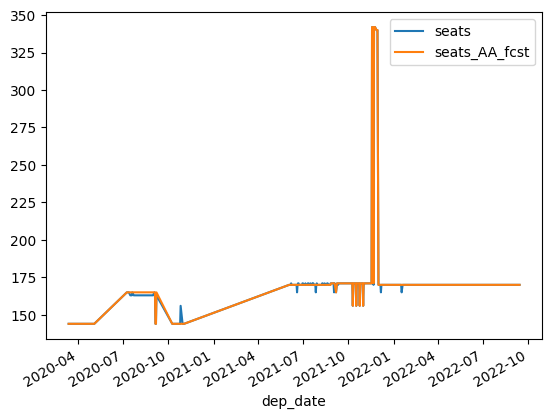

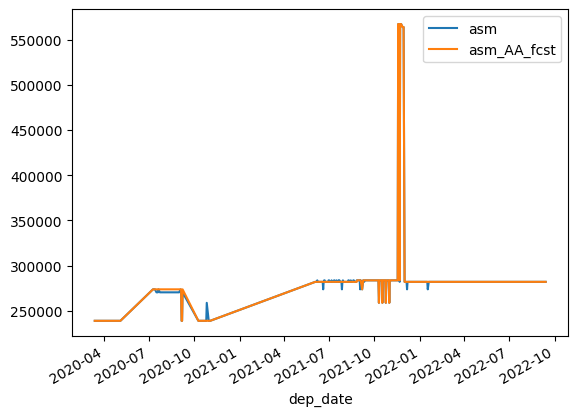

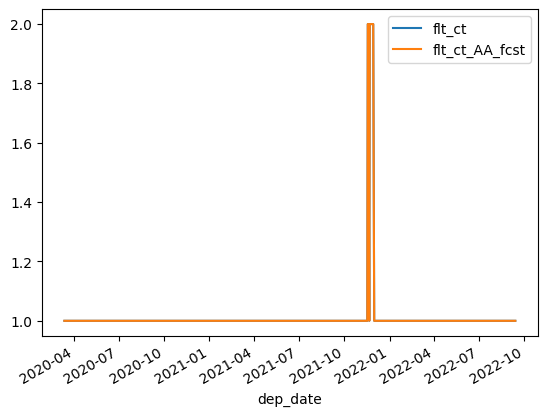

In [12]:
# Lets compare this results:

filter_date = oag_kl['adj_dep_date']<='2022-09-13'


oag_k2 = oag_kl[filter_date]
oag_k2.rename(columns={'adj_dep_date':'dep_date'}, inplace=True)


oag_cap_k2 = pd.merge(cap_kl.loc[:,["dep_date", "seats",	"asm"	,"flt_ct"]]	,oag_k2.loc[:,["dep_date","seats_AA_fcst",	"asm_AA_fcst",	"flt_ct_AA_fcst"]],on=['dep_date'],how='left',suffixes=('_cap', '_oag'))

filter1 =  oag_cap_k2['dep_date']<='2022-09-13'
filter2 = '2020-03-13' <= oag_cap_k2['dep_date']

oag_cap_k2[filter1 & filter2].plot.line(x="dep_date" ,  y=['seats','seats_AA_fcst'])
oag_cap_k2[filter1 & filter2].plot.line(x="dep_date" ,  y=['asm','asm_AA_fcst'])
oag_cap_k2[filter1 & filter2].plot.line(x="dep_date" ,  y=['flt_ct','flt_ct_AA_fcst'])




In [13]:
# Flights that are not avilable in the other table CAP (Maybe No flights flew that day?!)
oag_cap_k3 = pd.merge(cap_kl.loc[:,["dep_date", "seats",	"asm"	,"flt_ct"]]	,oag_k2.loc[:,["dep_date","seats_AA_fcst",	"asm_AA_fcst",	"flt_ct_AA_fcst"]],on=['dep_date'],how='outer',suffixes=('_cap', '_oag'), indicator=True)

filter1 = oag_cap_k3['_merge']  == 'left_only'
filter2 = oag_cap_k3['_merge']  == 'right_only'
filter_data1 = oag_cap_k3['dep_date']<='2022-09-13'
filter_data2 = oag_cap_k3['dep_date']  > '2018-09-13'

oag_cap_k3[filter_data1& filter_data2][filter1 | filter2 ]
# oag_cap_k3[filter1 | filter2 ]
# oag_cap_k3[filter_data1& filter_data2][filter2]
# oag_cap_k3[filter_data1& filter_data2][filter1]

C:\Users\250318\AppData\Local\Temp\1\ipykernel_3104\3801078027.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  oag_cap_k3[filter_data1& filter_data2][filter1 | filter2 ]


,dep_date,seats,asm,flt_ct,seats_AA_fcst,asm_AA_fcst,flt_ct_AA_fcst,_merge
1265,2019-03-11,NaN,NaN,NaN,156.0,258804.0,1.0,right_only
1266,2019-03-15,NaN,NaN,NaN,156.0,258804.0,1.0,right_only
1267,2019-03-17,NaN,NaN,NaN,156.0,258804.0,1.0,right_only
1268,2019-03-18,NaN,NaN,NaN,156.0,258804.0,1.0,right_only
1269,2019-03-21,NaN,NaN,NaN,156.0,258804.0,1.0,right_only
1270,2019-03-22,NaN,NaN,NaN,156.0,258804.0,1.0,right_only
1271,2020-04-09,NaN,NaN,NaN,144.0,238896.0,1.0,right_only
1272,2022-01-07,NaN,NaN,NaN,170.0,282030.0,1.0,right_only


#### Mergfing AA Cap + AA/OA:


Here we merge both dataets on `dep_date`, and:
1. Merge on cap_K1 (so data from OAG when CAP data is None would not be inculded.) 
    - Either data is not included because all the flights on that data are canceled (I think)
2. 'seats','asm','airline','ulcc_ind' from the CAP are dropped (so we use the data gatherred from the OAG dataset, which might be less accuerate.)
3. Data are normalized using `minmax_scale`

In [14]:
# merge OAG and AA Cap data

oag_kl.rename(columns={'adj_dep_date':'dep_date'}, inplace=True)

oag_cap_kl = pd.merge(cap_kl,oag_kl,on=['dep_date'],how='left',suffixes=('_cap', '_oag'))

print(oag_cap_kl.isnull().sum())
oag_cap_kl.dropna(inplace=True)

oag_cap_kl

dep_date            0
seats               0
asm                 0
flt_ct              0
rpm                 0
                   ..
flt_ct_OA_fcst      0
flt_ct_ulcc_fcst    0
flt_ct_All_fcst     0
asm_AA_fcst         0
asm_All_fcst        0
Length: 22, dtype: int64


,dep_date,seats,asm,flt_ct,rpm,rev,pax,rasm,yield,load_fac,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst
0,2017-09-01,144,238896.0,1,179172.0,16439.5600,108,0.068815,0.091753,0.750000,886,995,144,0,0,144,1,0,0,1,238896,238896
1,2017-09-03,144,238896.0,1,149310.0,12089.2300,90,0.050605,0.080967,0.625000,886,995,144,0,0,144,1,0,0,1,238896,238896
2,2017-09-04,144,238896.0,1,227283.0,26754.8000,137,0.111994,0.117716,0.951389,886,995,144,0,0,144,1,0,0,1,238896,238896
3,2017-09-07,144,238896.0,1,162582.0,12888.6500,98,0.053951,0.079275,0.680556,886,995,144,0,0,144,1,0,0,1,238896,238896
4,2017-09-08,144,238896.0,1,192444.0,16827.5500,116,0.070439,0.087441,0.805556,886,995,144,0,0,144,1,0,0,1,238896,238896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,2022-10-30,170,282030.0,1,162582.0,15521.4777,98,0.055035,0.095469,0.576471,886,995,170,0,0,170,1,0,0,1,282030,282030
1259,2022-10-31,170,282030.0,1,149310.0,14316.0955,90,0.050761,0.095882,0.529412,886,995,170,0,0,170,1,0,0,1,282030,282030
1260,2022-11-01,170,282030.0,1,194103.0,15575.3592,117,0.055226,0.080243,0.688235,886,995,170,0,0,170,1,0,0,1,282030,282030
1261,2022-11-02,170,282030.0,1,164241.0,12972.7000,99,0.045998,0.078986,0.582353,886,995,170,0,0,170,1,0,0,1,282030,282030


In [15]:
# remove the 
oag_cap_kl.drop(columns=['seats','asm','flt_ct' , 'fcst_start' , 'fcst_end'],inplace=True)

# Normalize Cap features
norm_cols = ['rpm', 'rev', 'pax', 'rasm',
       'yield', 'load_fac', 'seats_AA_fcst',
       'seats_OA_fcst', 'seats_ulcc_fcst', 'seats_All_fcst', 'flt_ct_AA_fcst',
       'flt_ct_OA_fcst', 'flt_ct_ulcc_fcst', 'flt_ct_All_fcst', 'asm_AA_fcst',
       'asm_All_fcst']

oag_cap_kl[norm_cols] = minmax_scale(oag_cap_kl[norm_cols])
oag_cap_kl

,dep_date,rpm,rev,pax,rasm,yield,load_fac,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst
0,2017-09-01,0.310345,0.193777,0.310345,0.294655,0.388251,0.679245,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1,2017-09-03,0.258621,0.142498,0.258621,0.216682,0.342612,0.566038,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
2,2017-09-04,0.393678,0.315365,0.393678,0.479540,0.498112,0.861635,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
3,2017-09-07,0.281609,0.151921,0.281609,0.231010,0.335450,0.616352,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
4,2017-09-08,0.333333,0.198350,0.333333,0.301609,0.370006,0.729560,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,2022-10-30,0.281609,0.182955,0.281609,0.235651,0.403974,0.522087,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313
1259,2022-10-31,0.258621,0.168747,0.258621,0.217351,0.405722,0.479467,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313
1260,2022-11-01,0.336207,0.183590,0.336207,0.236469,0.339546,0.623307,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313
1261,2022-11-02,0.284483,0.152912,0.284483,0.196955,0.334227,0.527414,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313


## Data Pull - Koronos 2.0

Here we pull the data that have been used in the privious vesrion of Koronos. (including Trafic Data)

Important concepts:

- `Fare Closure`: price range that can be opened or closed based on a given bit price, float between 0 and 1, with 0 being fully open and 1 being completly closed. There are 10 diffierent price ranges.
- `forecastPeriod`: Period before flight Departs, 365 days shown in 1-7 range, with 7 being the furthest from the flight and 1 being closest to the flight dept. date.


|  snapshotDate |   origin   | destination |  forecastId | forecastDepartureDate | forecastDayOfWeek |                     poolCode                    |  cabinCode |                       forecastPeriod                       |            localFlowIndicator            | flightDepartureDate | fracClosure_1 | ... | fracClosure_10 |    trafficActual_1   | ... |   trafficActual_10   | trafficActualAadv_1 | ... | trafficActualAadv_10 |         holiday        |           H1          |           H2          |           H3          |           HL          |      weekNumber     |                 week_x                |                 week_y                |              dow_x             |              dow_y             | avgtraffic | avgtrafficopenness | avgrasm | dowavgtraffic | dowavgtrafficopenness | dowavgrasm |
|:-------------:|:----------:|:-----------:|:-----------:|:---------------------:|:-----------------:|:-----------------------------------------------:|:----------:|:----------------------------------------------------------:|:----------------------------------------:|:-------------------:|:-------------:|:---:|:--------------:|:--------------------:|:---:|:--------------------:|:-------------------:|:---:|:--------------------:|:----------------------:|:---------------------:|:---------------------:|:---------------------:|:---------------------:|:-------------------:|:-------------------------------------:|:-------------------------------------:|:------------------------------:|:------------------------------:|:----------:|:------------------:|:-------:|:-------------:|:---------------------:|:----------:|
| Snapshot Date | Origin Leg |   Dest Leg  | Forecast ID |  Forecast Dept. Date  |  Day of the Week  | Pool Code Showing Holiday or not (priority day) | Cabin Code | Period before flight Departs, 365 days shown in 1-7 range. | Local vs Flow Passenger seprator [F , L] |  Flight Dept. Date  |  Fare Closure | ... |  Fare Closure  | Actual Traffic in FC | ... | Actual Traffic in FC |  Acctual Traffic bought with miles         | ... |         Acctual Traffic bought with miles           | Holiday (1) or not (0) | Holiday type (binary) | Holiday type (binary) | Holiday type (binary) | Holiday type (binary) | Week Number in Year | Week Value (looked in a circular way) | Week Value (looked in a circular way) | DOW (looked in a circular way) | DOW (looked in a circular way) |   historical traffic avg. per week (calculated manually)    |    another traffic indicator (per week)   |     Historical calcualted  RSM    (per week)        |   historical traffic avg. based on day of week   |      another traffic indicator (based on day of week)            |     Historical calcualted  RSM    (based on day of week)     |


Unique Keys: `snapshotDate`, `origin`, `destination`, `forecastId`

**NOTE**: `trafficActual` colunms do include traffic from `trafficActualAadv` cols.

In [16]:
from pullDate_FullPeriod import pull_data , pull_seas 

In [17]:
# cd C:\Users\250318\Documents\Repos\sina_notebooks

In [18]:
# pull data from the file: pullData_FullPeriod.py
new_market = False
df = pull_data(orig,dest,fcst_id,new_market)
print(df.shape)

df = pull_seas(df, orig, dest)
print(df.shape)

df['flightDepartureDate'] = pd.to_datetime(df['flightDepartureDate'], format='%Y/%m/%d')
print((df['flightDepartureDate'].min(), df['flightDepartureDate'].max()))
print(df[(df['flightDepartureDate']>=Pre_start) & (df['flightDepartureDate']<=Pre_end)].shape)
print(df[(df['flightDepartureDate']>=Post_start) & (df['flightDepartureDate']<=Post_end)].shape)

df

C:\Users\250318\Anaconda3\envs\sina-env-conda\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\250318\Documents\Repos\sina_notebooks\pullDate_FullPeriod.py:441: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekNumber'] = pd.DatetimeIndex(df['forecastDepartureDate']).week
C:\Users\250318\Anaconda3\envs\sina-env-conda\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.

(16608, 51)
(16608, 57)
(Timestamp('2017-09-03 00:00:00'), Timestamp('2023-04-06 00:00:00'))
(10184, 57)
(5738, 57)


,snapshotDate,origin,destination,forecastId,forecastDepartureDate,forecastDayOfWeek,poolCode,cabinCode,forecastPeriod,localFlowIndicator,flightDepartureDate,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm
0,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,1,F,2017-09-03,0.0,0.000,0.000,0.004,0.015,0.029,0.029,0.029,0.033,0.117,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000
1,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,2,F,2017-09-03,0.0,0.000,0.000,0.000,0.000,0.000,0.015,0.029,0.029,0.455,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000
2,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,3,F,2017-09-03,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.044,0.662,0.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000
3,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,4,F,2017-09-03,0.0,0.000,0.000,0.000,0.000,0.000,0.005,0.070,0.987,1.000,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000
4,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,5,F,2017-09-03,0.0,0.000,0.000,0.000,0.000,0.004,0.075,0.735,1.000,1.000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16603,2022-11-08,SEA,DFW,7,2022-08-27,6,M,Y,3,L,2022-08-27,0.0,0.093,0.414,0.995,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,34,0.185980,0.110216,0.381,0.000,0.044,0.145,0.328,0.000,0.227,0.457
16604,2022-11-08,SEA,DFW,7,2022-08-27,6,M,Y,4,L,2022-08-27,0.0,0.092,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,34,0.185980,0.110216,0.381,0.000,0.044,0.145,0.328,0.000,0.227,0.457
16605,2022-11-08,SEA,DFW,7,2022-08-27,6,M,Y,5,L,2022-08-27,0.0,0.193,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,34,0.185980,0.110216,0.381,0.000,0.044,0.145,0.328,0.000,0.227,0.457
16606,2022-11-08,SEA,DFW,7,2022-08-27,6,M,Y,6,L,2022-08-27,0.0,0.057,0.507,0.805,0.816,0.816,0.993,1.000,1.000,1.000,0.0,6.0,4.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,34,0.185980,0.110216,0.381,0.000,0.044,0.145,0.328,0.000,0.227,0.457


### Merge Koronos 2.0 with new features

In [19]:
print(df.shape)

# # merge new features into current Kronos dataset by dep_date
# df = pd.merge(df,oag_cap_kl, left_on=['flightDepartureDate'],\
#               right_on=['dep_date'], how='left')

# merge new features (including the total day seats) into current Kronos dataset by dep_date
df = pd.merge(df,oag_kl_fcst_total, left_on=['flightDepartureDate'],\
              right_on=['adj_dep_date'], how='left')
# check N/A
print(df.isnull().sum())
df.dropna(inplace=True)
df

(16608, 57)
snapshotDate               0
origin                     0
destination                0
forecastId                 0
forecastDepartureDate      0
                        ... 
flt_ct_OA                184
flt_ct_ulcc              184
flt_ct_All               184
asm_AA                   184
asm_All                  184
Length: 80, dtype: int64


,snapshotDate,origin,destination,forecastId,forecastDepartureDate,forecastDayOfWeek,poolCode,cabinCode,forecastPeriod,localFlowIndicator,flightDepartureDate,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All
0,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,1,F,2017-09-03,0.0,0.000,0.000,0.004,0.015,0.029,0.029,0.029,0.033,0.117,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384
1,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,2,F,2017-09-03,0.0,0.000,0.000,0.000,0.000,0.000,0.015,0.029,0.029,0.455,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384
2,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,3,F,2017-09-03,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.044,0.662,0.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384
3,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,4,F,2017-09-03,0.0,0.000,0.000,0.000,0.000,0.000,0.005,0.070,0.987,1.000,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384
4,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,5,F,2017-09-03,0.0,0.000,0.000,0.000,0.000,0.004,0.075,0.735,1.000,1.000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16603,2022-11-08,SEA,DFW,7,2022-08-27,6,M,Y,3,L,2022-08-27,0.0,0.093,0.414,0.995,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,34,0.185980,0.110216,0.381,0.000,0.044,0.145,0.328,0.000,0.227,0.457,2022-08-27,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.492784,0.750000,0.0,0.576702,0.444444,0.75,0.0,0.538462,0.492784,0.576702
16

## Creating group for each flight:

Identify and padding the unique group

Each group contains 14 rows (local/flow, 7 fcst_perd) x 10 cols (frac_closure).

Each flight is a group!

Added Features:
|  groupID   	|   fullHistory |     real    | 
|:-------------:|:-------------:|:-----------:|
|  Specific flight |   if 14 means we have full history (complete group)      | indicator showing this data is real (1) - 1 for all of this table | 

In [20]:

df = df.sort_values(['snapshotDate','origin','destination',
                            'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                             'cabinCode','localFlowIndicator'])

# 'GroupBy.cumcount': Number each item in each group from 0 to (the length of that group - 1).
# '== 0' returns True or False
# '.astype(int)' ,convert True/False to 1/0
df['groupID'] = (df.groupby(['snapshotDate','origin','destination',
                            'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                             'cabinCode']).cumcount() == 0).astype(int)
# assign each unique group a new group id
# groupID==1 will be a new id (+1), groupID==0 will indicate the same id for the same group
df['groupID'] = df['groupID'].cumsum()

# Full Hisxtory Pre Fixing
# count the num of 'forecastPeriod' in each group
# because some group might not have all 7 'forecastPeriod'
df['fullHistory'] = df.groupby(['groupID'])["forecastPeriod"].transform("count")
# Indicator it is part of history and not a pad
df['real'] = 1
df

,snapshotDate,origin,destination,forecastId,forecastDepartureDate,forecastDayOfWeek,poolCode,cabinCode,forecastPeriod,localFlowIndicator,flightDepartureDate,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All,groupID,fullHistory,real
0,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,1,F,2017-09-03,0.0,0.0,0.0,0.004,0.015,0.029,0.029,0.029,0.033,0.117,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1
1,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,2,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.015,0.029,0.029,0.455,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1
2,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,3,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.044,0.662,0.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1
3,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,4,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.005,0.070,0.987,1.000,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1
4,2022-11-08,SEA,DFW,7,2017-09-03,7,HL,Y,5,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.004,0.075,0.735,1.000,1.000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,1,35,0.234948,0.075404,0.809,0.098,0.221,0.160,0.296,0.384,1.000,1.000,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10478,2022-11-08,SEA,DFW,7,2023-04-04,2,M,Y,7,L,2023-04-04,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.026,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,14,0.469766,0.999171,0.809,0.890,0.459,0.584,0.926,0.095,0.083,0.123,2023-04-04,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.839175,0.750000,0.0,0.818313

In [20]:
df.shape

(16312, 83)

### Empty group for padding:

Here we create an empty group, with 14 rows and 50 columns (origenal Koronos 2.0)


In [21]:
fullKeysArray = np.zeros( (14, 50) ) # 'fullKeys' uses 50 columns 

# frac_closure = 0: fully closed with 0 traffic
for i in range(0,fullKeysArray.shape[0]): 
    if i <= 6: # Flow: 0 ~ 6
        fullKeysArray[i][0] = 1 # 'localFlowIndicator' column
        fullKeysArray[i][1] = i + 1 # 'forecastPeriod' column: 1 ~ 7
        fullKeysArray[i][2:12] = 1 # 'fracClosure' column all set to 1 
    else: # Local: 7 ~ 13s
        fullKeysArray[i][0] = 0 # 'localFlowIndicator' column
        fullKeysArray[i][1] = i - 6 # 'forecastPeriod' column: 1 ~ 7
        fullKeysArray[i][2:12] = 1 # 'fracClosure' column: all set to 1 
        
fullKeys = pd.DataFrame(fullKeysArray)        
fullKeys.columns = ['localFlowIndicator','forecastPeriod'] + [f"fracClosure_{i}" for i in range(1,11)] + [f"trafficActual_{i}" for i in range(1,11)] + [f"trafficActualAadv_{i}" for i in range(1,11)] + ['holiday','H1','H2','H3','HL','weekNumber','week_x','week_y','dow_x','dow_y','avgtraffic','avgtrafficopenness','avgrasm','dowavgtraffic','dowavgtrafficopenness','dowavgrasm','groupID','fullHistory']
fullKeys['localFlowIndicator'] = ['F' if lfi == 1 else 'L' for lfi in fullKeys['localFlowIndicator']]
fullKeys

,localFlowIndicator,forecastPeriod,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm,groupID,fullHistory
0,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,F,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,F,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,F,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,F,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,F,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,F,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,L,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,L,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,L,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Padding:
Now that we have the empty group we populate the data that is incomplete.

In [22]:
groupbyColumns = ['snapshotDate','origin','destination','forecastId','flightDepartureDate',
                  'forecastDayOfWeek','poolCode','cabinCode']
grouped = df[df['flightDepartureDate'] <= Post_end].groupby(groupbyColumns)

merged_list = []
count_rows_misskey = 0
for g in grouped:
    
    # g[0] is the directory key and g[1] is the value (actual data)
    # identify the cells of g[1] that not in fullKeys
    # g[1][~g[1].isin(fullKeys)] 
    
    # identify the missing keys in g[1]
    key = g[1][['localFlowIndicator','forecastPeriod']]
    missingKeys = fullKeys[~fullKeys[['localFlowIndicator','forecastPeriod']].apply(tuple,1).isin(key.apply(tuple,1))]
    count_rows_misskey += missingKeys.shape[0]
    
    # append the missing keys under the data
    fullHistory = pd.concat([g[1],missingKeys])
    
    # use 0 to indicate padding data
    fullHistory['real'].fillna(0, inplace=True) 
    
    # fill the data with missing keys
    fullHistory = fullHistory.fillna(method='ffill')
    merged_list.append(fullHistory)
    
# merge all data across 'flightDepartureDate'   
out = pd.concat(merged_list)
out = out.sort_values(['snapshotDate','origin','destination',
                            'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                             'cabinCode','localFlowIndicator'])
out

,snapshotDate,origin,destination,forecastId,forecastDepartureDate,forecastDayOfWeek,poolCode,cabinCode,forecastPeriod,localFlowIndicator,flightDepartureDate,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All,groupID,fullHistory,real
0,2022-11-08,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,1.0,F,2017-09-03,0.0,0.0,0.0,0.004,0.015,0.029,0.029,0.029,0.033,0.117,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.384,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1.0,14.0,1.0
1,2022-11-08,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,2.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.015,0.029,0.029,0.455,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.384,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1.0,14.0,1.0
2,2022-11-08,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,3.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.044,0.662,0.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.384,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1.0,14.0,1.0
3,2022-11-08,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,4.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.005,0.070,0.987,1.000,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.384,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1.0,14.0,1.0
4,2022-11-08,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,5.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.004,0.075,0.735,1.000,1.000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.384,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1.0,14.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,2022-11-08,SEA,DFW,7.0,2023-04-06,4.0,H3,Y,2.0,L,2023-04-06,1.0,1.0,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.000,0.000,0.00,0.000,0.000,0.0,0.0,2023-04-0

In [23]:
# Get full history and then concat fake history (padding) from above 
post = out.copy()
post = post.sort_values(['snapshotDate','origin','destination',
                            'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                             'cabinCode','localFlowIndicator'])


post['groupID'] = (post.groupby(['snapshotDate','origin','destination',
                            'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                             'cabinCode']).cumcount()==0).astype(int)
post['groupID'] = post['groupID'].cumsum()
# Full Hisotyr Pre Fixing
post['fullHistory'] = post.groupby(['groupID'])["forecastPeriod"].transform("count")

post['flightDepartureDate'] = pd.to_datetime(post['flightDepartureDate'], format='%Y/%m/%d')

post

,snapshotDate,origin,destination,forecastId,forecastDepartureDate,forecastDayOfWeek,poolCode,cabinCode,forecastPeriod,localFlowIndicator,flightDepartureDate,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All,groupID,fullHistory,real
0,2022-11-08,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,1.0,F,2017-09-03,0.0,0.0,0.0,0.004,0.015,0.029,0.029,0.029,0.033,0.117,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.384,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1.0
1,2022-11-08,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,2.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.015,0.029,0.029,0.455,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.384,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1.0
2,2022-11-08,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,3.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.044,0.662,0.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.384,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1.0
3,2022-11-08,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,4.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.005,0.070,0.987,1.000,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.384,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1.0
4,2022-11-08,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,5.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.004,0.075,0.735,1.000,1.000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.384,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,2022-11-08,SEA,DFW,7.0,2023-04-06,4.0,H3,Y,2.0,L,2023-04-06,1.0,1.0,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.000,0.000,0.00,0.000,0.000,0.0,0.0,2023-04-06,886.0,995.0,0.1313

In [31]:
post = post.sort_values(['forecastDepartureDate','origin','destination',
                            'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                             'cabinCode','localFlowIndicator'])

## Train, Eval, Test Splits

Now lets divide the data into train, eval, and test subsets.

PRE: For train and eval
POST: For test

In [38]:
# Pre: pre-covid period, used for train and validation
Pre_start, Pre_end = '2017-09-01', '2020-01-30'
# Post: post-covid period, used for test
Post_start, Post_end = '2021-07-01', '2022-06-30'


# Cut the 'post' data into Pre-covid and Post-covid parts
Data_PRE = post[ (post['flightDepartureDate']>=Pre_start) & (post['flightDepartureDate']<=Pre_end) ]
Data_POST = post[ (post['flightDepartureDate']>=Post_start) & (post['flightDepartureDate']<=Post_end) ]

print(Data_PRE.shape)
print(Data_POST.shape)

(10178, 83)
(3626, 83)


In [40]:
Data_POST[-14:]

,snapshotDate,origin,destination,forecastId,forecastDepartureDate,forecastDayOfWeek,poolCode,cabinCode,forecastPeriod,localFlowIndicator,flightDepartureDate,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All,groupID,fullHistory,real
5898,2022-11-08,SEA,DFW,7.0,2022-06-30,4.0,H1,Y,1.0,F,2022-06-30,0.004,0.007,0.015,0.147,0.424,0.803,0.834,0.900,0.900,0.930,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.374,0.523,0.673,0.26,0.442,0.405,2022-06-30,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.483162,1.0,0.0,0.647651,0.444444,1.0,0.0,0.615385,0.483162,0.647651,1035,14,1.0
5899,2022-11-08,SEA,DFW,7.0,2022-06-30,4.0,H1,Y,2.0,F,2022-06-30,0.000,0.006,0.092,0.563,0.839,0.996,1.000,1.000,1.000,1.000,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.374,0.523,0.673,0.26,0.442,0.405,2022-06-30,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.483162,1.0,0.0,0.647651,0.444444,1.0,0.0,0.615385,0.483162,0.647651,1035,14,1.0
5900,2022-11-08,SEA,DFW,7.0,2022-06-30,4.0,H1,Y,3.0,F,2022-06-30,0.000,0.046,0.501,0.992,1.000,1.000,1.000,1.000,1.000,1.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.374,0.523,0.673,0.26,0.442,0.405,2022-06-30,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.483162,1.0,0.0,0.647651,0.444444,1.0,0.0,0.615385,0.483162,0.647651,1035,14,1.0
5901,2022-11-08,SEA,DFW,7.0,2022-06-30,4.0,H1,Y,4.0,F,2022-06-30,0.000,0.117,0.770,0.998,1.000,1.000,1.000,1.000,1.000,1.000,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.374,0.523,0.673,0.26,0.442,0.405,2022-06-30,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.483162,1.0,0.0,0.647651,0.444444,1.0,0.0,0.615385,0.483162,0.647651,1035,14,1.0
5902,2022-11-08,SEA,DFW,7.0,2022-06-30,4.0,H1,Y,5.0,F,2022-06-30,0.000,0.191,0.633,0.914,0.999,1.000,1.000,1.000,1.000,1.000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.374,0.523,0.673,0.26,0.442,0.405,2022-06-30,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.483162,1.0,0.0,0.647651,0.444444,1.0,0.0,0.615385,0.483162,0.647651,1035,14,1.0
5903,2022-11-08,SEA,DFW,7.0,2022-06-30,4.0,H1,Y,6.0,F,2022-06-30,0.000,0.001,0.040,0.186,0.491,0.827,0.922,0.927,0.927,0.927,1.0,0.0,0.0,0.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,26.0,0.000718,0.534132,0.037,0.713,0.374,0.523,0.673,0.26,0.442,0.405,2022-06-30,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.483162,1.0,0.0,0.647651,0.444444,1.0,0.0,0.615385,0.483162,0.647651,1035,14,1.0
5904,2022-11-08,SEA,DFW,7.0,2022-06-30,4.0,H1,Y,7.0,F,2022-06-30,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0

### Kronos 2.0 Data:

This is the data proceesing for the current Kronos 2.0 model

In [766]:
# Run Kronos Model Test from HERE
sea_col = ['week_x', 'week_y', 'dow_x', 'dow_y','avgrasm','dowavgrasm']
sea_len = len(sea_col)


# PRE
# fractional closure
PRE_FC_L = Data_PRE[['fracClosure_' + str(i + 1) for i in range(10)]].values.astype('float32')
# seasonality
PRE_Sea_L = Data_PRE[sea_col].values.astype('float32')
# actual traffic
PRE_Traf_L = Data_PRE[['trafficActual_' + str(i + 1) for i in range(10)]].values.astype('float32')

# reshape the data for CNNLSTM model
PRE_FC = PRE_FC_L.reshape(int(PRE_FC_L.shape[0]/14), 1, 14, 10)
PRE_Sea = PRE_Sea_L.reshape(int(PRE_Sea_L.shape[0]/14), 1,14, sea_len)
PRE_Traf = PRE_Traf_L.reshape(int(PRE_Traf_L.shape[0]/14), 1, 14, 10)

print([PRE_FC.shape[0],PRE_Sea.shape[0],PRE_Traf.shape[0]])

# 80% train, 20% val
train_test_cutoff = round(PRE_FC.shape[0]*0.8) 
# prepare train/val/test datasets
# FC
PRE_FC_train = PRE_FC[:train_test_cutoff, :]
PRE_FC_val = PRE_FC[train_test_cutoff:, :]
# Sea
PRE_Sea_train = PRE_Sea[:train_test_cutoff, :]
PRE_Sea_val = PRE_Sea[train_test_cutoff:, :]
# Traf
PRE_Traf_train = PRE_Traf[:train_test_cutoff, :]
PRE_Traf_val = PRE_Traf[train_test_cutoff:, :]

# POST
# fractional closure
POST_FC_L = Data_POST[['fracClosure_' + str(i + 1) for i in range(10)]].values.astype('float32')
# seasonality
POST_Sea_L = Data_POST[sea_col].values.astype('float32')


# reshape the data for CNNLSTM model
POST_FC = POST_FC_L.reshape(int(POST_FC_L.shape[0]/14), 1, 14, 10)
POST_Sea = POST_Sea_L.reshape(int(POST_Sea_L.shape[0]/14), 1,14, sea_len)




[727, 727, 727]


### New Kronos input with Cap features
With Cap features: train/val/test

!!! modify here to select the new features

In [767]:
# !!! Change Seasonality (Capacity + new features) HERE !!! 
#--> Lets include AA, OA, ULCC seates based on the FCST and day total.
sea_col_Cap = ['week_x', 'week_y','dow_x', 'dow_y', 'avgrasm','seats_AA_fcst','seats_OA_fcst','seats_ulcc_fcst' , 'seats_AA' , 'seats_OA' , 'seats_ulcc']
sea_len_Cap = len(sea_col_Cap)
########################################################


# PRE
# seasonality
PRE_Sea_L_Cap = Data_PRE[sea_col_Cap].values.astype('float32')

### Here we generate 14 of same rows for each seasenality !! (one should be enough!)
# reshape the data for CNNLSTM model
PRE_Sea_Cap = PRE_Sea_L_Cap.reshape(int(PRE_Sea_L_Cap.shape[0]/14), 1,14, sea_len_Cap)


print(PRE_Sea_Cap.shape )

# 80% train, 20% val
train_test_cutoff = round(PRE_FC.shape[0]*0.8) 
# prepare train/val/test datasets
# Sea
PRE_Sea_train_Cap = PRE_Sea_Cap[:train_test_cutoff, :]
PRE_Sea_val_Cap = PRE_Sea_Cap[train_test_cutoff:, :]


# POST
# seasonality
POST_Sea_L_Cap = Data_POST[sea_col_Cap].values.astype('float32')
# reshape the data for CNNLSTM model
POST_Sea_Cap = POST_Sea_L_Cap.reshape(int(POST_Sea_L_Cap.shape[0]/14), 1,14, sea_len_Cap)





(727, 1, 14, 11)


### Create the train, val, test sets

In [768]:
# current Kronos input (No Cap data)
train_base = [PRE_FC_train,PRE_Sea_train,PRE_Traf_train]
val_base = [PRE_FC_val,PRE_Sea_val,PRE_Traf_val]
test_base = [POST_FC,POST_Sea]
# Kronos input with new features (With Cap data)
train_Cap = [PRE_FC_train,PRE_Sea_train_Cap,PRE_Traf_train]
val_Cap = [PRE_FC_val,PRE_Sea_val_Cap,PRE_Traf_val]
test_Cap = [POST_FC,POST_Sea_Cap]


#### Traffic, Seasonality (old version) , FC

In [769]:
# Train and Val:
# FC
PRE_FC_train_2s = PRE_FC_train.reshape(len(PRE_FC_train),2,7,10)
PRE_FC_val_2s = PRE_FC_val.reshape(len(PRE_FC_val),2,7,10)
# Sea
PRE_Sea_train_2s = np.delete(PRE_Sea_train, slice(13), 2).reshape(PRE_Sea_train.shape[0], PRE_Sea_train.shape[3])
PRE_Sea_val_2s =  np.delete(PRE_Sea_val, slice(13), 2).reshape(PRE_Sea_val.shape[0], PRE_Sea_val.shape[3])
# Traf
PRE_Traf_train_2s = PRE_Traf_train.reshape(len(PRE_Traf_train),2,7,10)
PRE_Traf_val_2s = PRE_Traf_val.reshape(len(PRE_Traf_val),2,7,10)

# Test:
POST_FC_2s = POST_FC.reshape(len(POST_FC),2,7,10)
POST_Sea_2s = np.delete(POST_Sea, slice(13), 2).reshape(POST_Sea.shape[0], POST_Sea.shape[3])

print(PRE_FC_train_2s.shape , PRE_Sea_train_2s.shape , PRE_Traf_train_2s.shape , POST_FC_2s.shape )

(582, 2, 7, 10) (582, 6) (582, 2, 7, 10) (259, 2, 7, 10)


#### Seasonality (Cap+OA):


In [770]:
# Train, and Val:
PRE_Sea_train_Cap_2s = np.delete(PRE_Sea_train_Cap, slice(13), 2).reshape(len(PRE_Sea_train_Cap), 11)
PRE_Sea_val_Cap_2s = np.delete(PRE_Sea_val_Cap, slice(13), 2).reshape(len(PRE_Sea_val_Cap), 11)

# Test:
POST_Sea_Cap_2s =np.delete(POST_Sea_Cap, slice(13), 2).reshape(len(POST_Sea_Cap), 11)

print(PRE_Sea_train_Cap_2s.shape, PRE_Sea_val_Cap_2s.shape, POST_Sea_Cap_2s.shape)

(582, 11) (145, 11) (259, 11)


#### Create Kronos 2S test, val, and train:

In [771]:
# current Kronos input (No Cap data)
train_base_2s = [PRE_FC_train_2s,PRE_Sea_train_2s,PRE_Traf_train_2s]
val_base_2s = [PRE_FC_val_2s,PRE_Sea_val_2s,PRE_Traf_val_2s]
test_base_2s = [POST_FC_2s,POST_Sea_2s]
# Kronos input with new features (With Cap data)
train_Cap_2s = [PRE_FC_train_2s,PRE_Sea_train_Cap_2s,PRE_Traf_train_2s]
val_Cap_2s = [PRE_FC_val_2s,PRE_Sea_val_Cap_2s,PRE_Traf_val_2s]
test_Cap_2s = [POST_FC_2s,POST_Sea_Cap_2s]


# Kronos Model:

Here we define the Model.

In [ ]:
# Kronos Model
import os
from keras import backend as K 
from tensorflow.keras import Input
from tensorflow.keras.layers import ConvLSTM1D, Reshape , TimeDistributed, BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint



def Kronos_Model(para_epochs, para_early_stop, para_model_name, para_sea_len, para_sea_dense, train_list, val_list, test_list):

    
    # extract train/val/test datasets
    train_fc, train_sea, train_traf = train_list[0], train_list[1], train_list[2]
    val_fc, val_sea, val_traf = val_list[0], val_list[1], val_list[2]
    test_fc, test_sea = test_list[0], test_list[1]
    
    
    
    # Default Model Parameters
    batch_size = 100
    early_stop = 100
    filter_num = 16
    rec_act = 'relu'
    rec_dropout = 0.1
    lstm_size = 128
    patience= early_stop
    batch_size_nbr = batch_size
    Error_Method = 'MC_dropout'
    B = batch_size
    
    
    # Model 
    K.clear_session()
    input_tensor_closure = Input(shape = (1,14,10))
    input_tensor_seas = Input(shape = (1,14,para_sea_len))
    
    # Layer for frac_closure
    cnn_lstm_closure = ConvLSTM1D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_closure)
    cnn_lstm_closure = BatchNormalization(axis = -1)(cnn_lstm_closure)
    cnn_lstm_closure = TimeDistributed(Flatten())(cnn_lstm_closure)
    cnn_lstm_closure = TimeDistributed(Dense(160))(cnn_lstm_closure)

    # layer for seasonality
    cnn_lstm_seas = ConvLSTM1D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_seas)
    cnn_lstm_seas = BatchNormalization(axis = -1)(cnn_lstm_seas)
    cnn_lstm_seas = TimeDistributed(Flatten())(cnn_lstm_seas)
    cnn_lstm_seas = TimeDistributed(Dense(para_sea_dense))(cnn_lstm_seas)

    # concat frac_closure and seasonality
    cnn_lstm = Concatenate()([cnn_lstm_closure, cnn_lstm_seas])
    cnn_lstm = LSTM(lstm_size, input_shape = [1,160+para_sea_dense], return_sequences = True)(cnn_lstm)

    # output format
    output_tensor = TimeDistributed(Dense(140, activation = 'relu'))(cnn_lstm)
    output_tensor = Reshape((1, 14, 10))(output_tensor)

    # Kronos model setting
    Kronos_model = Model(inputs = [input_tensor_closure, input_tensor_seas], outputs = output_tensor)
    Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

    
    if para_early_stop: # with early stop
        
        os.chdir(r"\\corpaa.aa.com\campusshared\HDQ\HDQ_REVMGMT_Share\RMDEPT")
        path = "BFox/Kronos/Prototype/Output/FullPeriod/"
        market_nm = orig + dest
        # if not os.path.exists(path):
            # os.mkdir(path)
        
        history = History()
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)
        mc = ModelCheckpoint(path + '//' + market_nm + '_' + 'best_model.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True, period=1)
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0, callbacks=[history,es,mc])
    else: # no early stop
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0)
         
    
    # use the trained model to predict
#     train_pred = Kronos_model.predict([train_fc, train_sea])
#     val_pred = Kronos_model.predict([val_fc, val_sea])
    test_pred = Kronos_model.predict([test_fc, test_sea])

    # copy of train/test/val dataset to store prediction results
#     train_df = Data_PRE[0:train_test_cutoff*14].copy()
#     val_df = Data_PRE[train_test_cutoff*14:].copy()
    test_df = Data_POST.copy()
    
    
    # put the predictoin results from train/test/val sets together with the original data
    # train set
#     cls = {k:[] for k in range(1,11)}
#     for i,plane in enumerate(train_pred):
#         for j,row in enumerate(plane):
#             for k,col in enumerate(row):
#                 for idx in range(1,11):
#                     cls[idx].append(col[idx-1])        
#     # append to the train dataset
#     for idx in range(1,11):
#         train_df[f'pred{idx}'] = cls[idx]
#     train_df['dataset'] = 'train'
#     train_df['model'] = para_model_name
    
    
    # val set
#     cls = {k:[] for k in range(1,11)}
#     for i,plane in enumerate(val_pred):
#         for j,row in enumerate(plane):
#             for k,col in enumerate(row):
#                 for idx in range(1,11):
#                     cls[idx].append(col[idx-1]) 
#     # append to the val dataset
#     for idx in range(1,11):
#         val_df[f'pred{idx}'] = cls[idx]
#     val_df['dataset'] = 'val'
#     val_df['model'] = para_model_name
    
     
    # test set
    cls = {k:[] for k in range(1,11)}
    for i,plane in enumerate(test_pred):
        for j,row in enumerate(plane):
            for k,col in enumerate(row):
                for idx in range(1,11):
                    cls[idx].append(col[idx-1])
    # append to the val dataset
    for idx in range(1,11):
        test_df[f'pred{idx}'] = cls[idx]  
    test_df['dataset'] = 'test'
    test_df['model'] = para_model_name
    
    
    # append all results below (col num stay the same)
#     all_test = train_df.append(val_df)
#     all_test = all_test.append(test_df)
    all_test = test_df
    
    
    # calculate mean/std/MSE
    all_test['yr'] = all_test['flightDepartureDate'].dt.year
    all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

    # actual traffic
    all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
    all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
    all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
    all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
    # all predictions
    all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
    all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
    all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
    all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
    # all FvT errors
    all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
    all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
    all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
    all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
    # squared FvT errors for MSE
    all_test['top_FvT_sqr'] = all_test['top_FvT']**2
    all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
    all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
    all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2
    
    all_test = all_test[ (all_test['real']==1)]
    

    return all_test, base_hist, Kronos_model


### Data Vizualization

Before going to the train, lets look at the data that we are feeding the model:

In [36]:
train_base[1].shape

(582, 1, 14, 6)

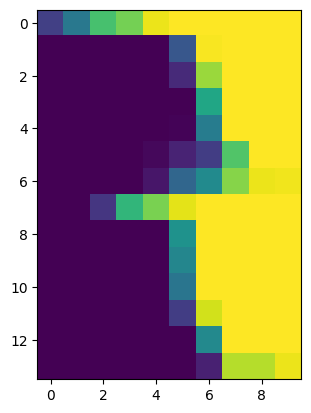

In [37]:

from PIL import Image as im


# For fun get to see what that looks like in 'pixel' form. This is the 'Picture' that we will convolve
img1 = im.fromarray(np.uint8(train_Cap[0][1][0]*100))
imgplot1 = plt.imshow(img1)

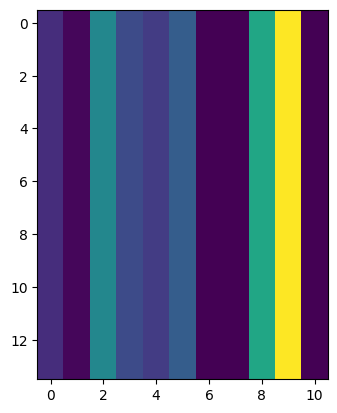

In [38]:
# For fun get to see what that looks like in 'pixel' form. This is the 'Picture' that we will convolve
img = im.fromarray(np.uint8(train_Cap[1][1][0]*100))
imgplot = plt.imshow(img)



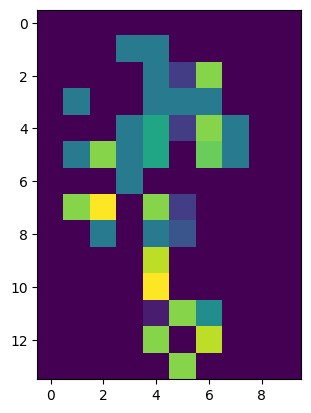

In [39]:
## Trrafic
img = im.fromarray(np.uint8(train_Cap[2][1][0]*100))
imgplot = plt.imshow(img)

### Model Training

Lets train the model.

In [ ]:
# (107,1,14,10)

In [ ]:

# input to the Kronos_Model function
# def Kronos_Model(para_epochs, para_early_stop, para_model_name, para_sea_len, para_sea_dense,\
#                  train_list, val_list, test_list):
  
# baseline model (current Kronos 2.0)
ret_base, base_hist , base_model = Kronos_Model(300, True, 'base', sea_len, 4,
             train_base, val_base, test_base)
# para model (current Kronos 2.0 with hyperparameter changes)
ret_para, para_hist, _ = Kronos_Model(65, False, 'para', sea_len, 160,
             train_base, val_base, test_base)

# para_Cap (hyperparameter changes + new features)
ret_para_Cap, ret_para_hist, _ = Kronos_Model(65, False, 'para_Cap', sea_len_Cap, 160,
             train_Cap, val_Cap, test_Cap)
    
    
# save all returned results
ret_df = ret_base
ret_df = ret_df.append(ret_para)
ret_df = ret_df.append(ret_para_Cap)


In [ ]:
base_model.summary()

In [ ]:
plt.plot(base_hist.history['loss'])
plt.plot(base_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','test'] , loc = "upper left")
plt.show()

In [ ]:
# top/mid/bot/sum - FvT mean/std/MSE 
print('baseline')
print([ret_base['top_FvT'].mean(), ret_base['top_FvT'].std(), ret_base['top_FvT_sqr'].mean()])
print([ret_base['mid_FvT'].mean(), ret_base['mid_FvT'].std(), ret_base['mid_FvT_sqr'].mean()])
print([ret_base['bot_FvT'].mean(), ret_base['bot_FvT'].std(), ret_base['bot_FvT_sqr'].mean()])
print([ret_base['sum_FvT'].mean(), ret_base['sum_FvT'].std(), ret_base['sum_FvT_sqr'].mean()])

In [ ]:
# top/mid/bot/sum - FvT mean/std/MSE
print('para')
print([ret_para['top_FvT'].mean(), ret_para['top_FvT'].std(), ret_para['top_FvT_sqr'].mean()])
print([ret_para['mid_FvT'].mean(), ret_para['mid_FvT'].std(), ret_para['mid_FvT_sqr'].mean()])
print([ret_para['bot_FvT'].mean(), ret_para['bot_FvT'].std(), ret_para['bot_FvT_sqr'].mean()])
print([ret_para['sum_FvT'].mean(), ret_para['sum_FvT'].std(), ret_para['sum_FvT_sqr'].mean()])

In [ ]:
# top/mid/bot/sum - FvT mean/std/MSE
print('para_Cap')
print([ret_para_Cap['top_FvT'].mean(), ret_para_Cap['top_FvT'].std(), ret_para_Cap['top_FvT_sqr'].mean()])
print([ret_para_Cap['mid_FvT'].mean(), ret_para_Cap['mid_FvT'].std(), ret_para_Cap['mid_FvT_sqr'].mean()])
print([ret_para_Cap['bot_FvT'].mean(), ret_para_Cap['bot_FvT'].std(), ret_para_Cap['bot_FvT_sqr'].mean()])
print([ret_para_Cap['sum_FvT'].mean(), ret_para_Cap['sum_FvT'].std(), ret_para_Cap['sum_FvT_sqr'].mean()])


### Prediction Results:

Now lets look at our prediction visually:

In [ ]:
ret_df['yr'] = ret_df['adj_dep_date'].dt.year
ret_df['mo'] = ret_df['adj_dep_date'].dt.month
ret_df['wk'] = ret_df['adj_dep_date'].dt.isocalendar().week


gp_cols = ['model','flightDepartureDate','yr','wk']
agg_cols = {'sum_trf':'sum','sum_pred':'sum','top_trf':'sum','top_pred':'sum','mid_trf':'sum','mid_pred':'sum','bot_trf':'sum','bot_pred':'sum'}

sol = ret_df.groupby(gp_cols).agg(agg_cols).reset_index()
sol

In [ ]:
agg_cols = {'sum_trf':'mean','sum_pred':'mean','top_trf':'mean','top_pred':'mean','mid_trf':'mean','mid_pred':'mean','bot_trf':'mean','bot_pred':'mean'}

sol2 = sol.groupby(['model','yr','wk']).agg(agg_cols).reset_index()
sol2

In [ ]:
agg_cols = {'sum_trf':'mean','sum_pred':'mean','top_trf':'mean','top_pred':'mean','mid_trf':'mean','mid_pred':'mean','bot_trf':'mean','bot_pred':'mean'}

sol3 = sol2.groupby(['model','wk']).agg(agg_cols).reset_index()
sol3['wk'].nunique()


In [ ]:
ret_para_Cap.loc[:,'pred1':'pred10']

In [ ]:
ret_para_Cap.loc[:,'trafficActual_1':'trafficActual_10']

# Kronos 2S

### Reshape for Kronos 2S:

(2S= Kronos2 Sina's version):

here we reshape 2 things:

1. Reshape the seasonality to1D (since it has duplicate information)
2. Reshape the Traffic and FC to3D (from 2D, by adding the local flow indicator as an additional dimminsion)



#### Traffic, Seasonality (old version) , FC

In [772]:
# Train and Val:
# FC
PRE_FC_train_2s = PRE_FC_train.reshape(len(PRE_FC_train),2,7,10)
PRE_FC_val_2s = PRE_FC_val.reshape(len(PRE_FC_val),2,7,10)
# Sea
PRE_Sea_train_2s = np.delete(PRE_Sea_train, slice(13), 2)#.reshape(PRE_Sea_train.shape[0], 1 ,PRE_Sea_train.shape[3])
PRE_Sea_val_2s =  np.delete(PRE_Sea_val, slice(13), 2)#.reshape(PRE_Sea_val.shape[0], 1 , PRE_Sea_val.shape[3])
# Traf
PRE_Traf_train_2s = PRE_Traf_train.reshape(len(PRE_Traf_train),2,7,10)
PRE_Traf_val_2s = PRE_Traf_val.reshape(len(PRE_Traf_val),2,7,10)

# Test:
POST_FC_2s = POST_FC.reshape(len(POST_FC),2,7,10)
POST_Sea_2s = np.delete(POST_Sea, slice(13), 2)#.reshape(POST_Sea.shape[0], 1 , POST_Sea.shape[3])

print(PRE_FC_train_2s.shape , PRE_Sea_train_2s.shape , PRE_Traf_train_2s.shape , POST_FC_2s.shape )

(582, 2, 7, 10) (582, 1, 1, 6) (582, 2, 7, 10) (259, 2, 7, 10)


#### Seasonality (Cap+OA):


In [773]:
# Train, and Val:
PRE_Sea_train_Cap_2s = np.delete(PRE_Sea_train_Cap, slice(13), 2)#.reshape(len(PRE_Sea_train_Cap), 1, 11)
PRE_Sea_val_Cap_2s = np.delete(PRE_Sea_val_Cap, slice(13), 2)#.reshape(len(PRE_Sea_val_Cap), 1 ,11)

# Test:
POST_Sea_Cap_2s =np.delete(POST_Sea_Cap, slice(13), 2)#.reshape(len(POST_Sea_Cap), 1 , 11)

print(PRE_Sea_train_Cap_2s.shape, PRE_Sea_val_Cap_2s.shape, POST_Sea_Cap_2s.shape)

(582, 1, 1, 11) (145, 1, 1, 11) (259, 1, 1, 11)


#### Create Kronos 2S test, val, and train:

In [774]:
# current Kronos input (No Cap data)
train_base_2s = [PRE_FC_train_2s,PRE_Sea_train_2s,PRE_Traf_train_2s]
val_base_2s = [PRE_FC_val_2s,PRE_Sea_val_2s,PRE_Traf_val_2s]
test_base_2s = [POST_FC_2s,POST_Sea_2s]
# Kronos input with new features (With Cap data)
train_Cap_2s = [PRE_FC_train_2s,PRE_Sea_train_Cap_2s,PRE_Traf_train_2s]
val_Cap_2s = [PRE_FC_val_2s,PRE_Sea_val_Cap_2s,PRE_Traf_val_2s]
test_Cap_2s = [POST_FC_2s,POST_Sea_Cap_2s]


#### Display Data:

lets look at the data now that we added the Channels:


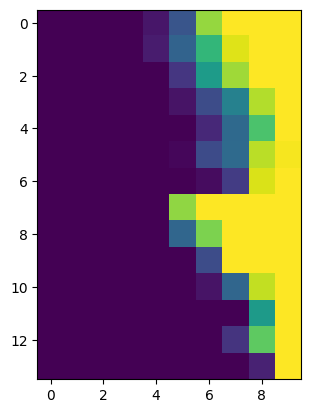

In [843]:
plt.imshow(train_Cap_2s[0][136].reshape(14,10))

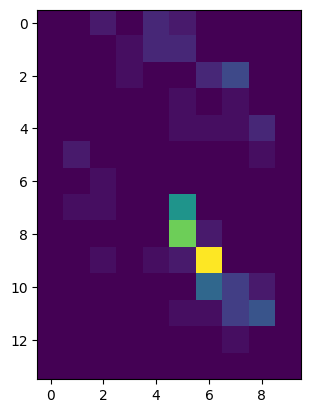

In [854]:
neg  = plt.imshow(train_Cap_2s[2][136].reshape(14,10))

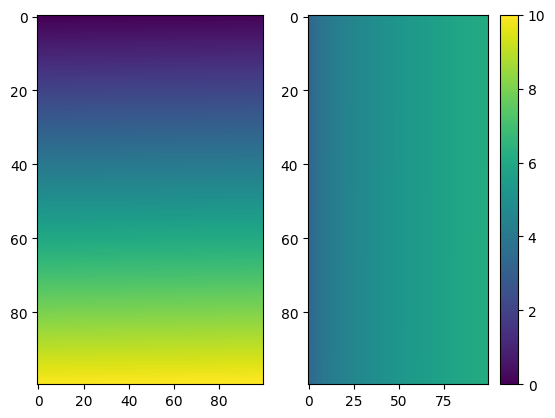

In [855]:
my_image1 = np.linspace(0, 10, 10000).reshape(100,100)
my_image2 = np.sqrt(my_image1.T) + 3
plt.subplot(1, 2, 1)
plt.imshow(my_image1, vmin=0, vmax=10, aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(my_image2, vmin=0, vmax=10, aspect='auto')
plt.colorbar()

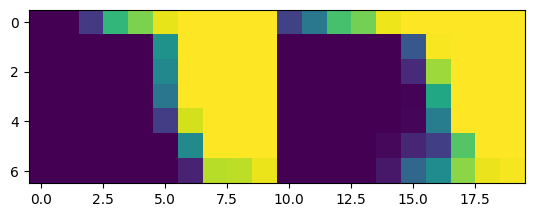

In [775]:
# FC
plt.imshow(np.hstack((train_Cap_2s[0][1][1] , (train_Cap_2s[0][1][0]))))

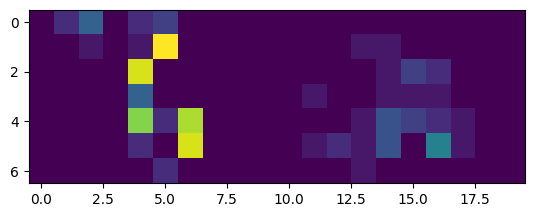

In [778]:
# Traffic:
cnp.hstack((train_Cap_2s[2][1][1] , (train_Cap_2s[2][1][0]))))
# plt.imshow(train_Cap_2s[2][1][1])

In [795]:
pd.DataFrame(train_Cap_2s[1][1].reshape(1,11))

,0,1,2,3,4,5,6,7,8,9,10
0,0.287736,0.046713,1.0,0.494,0.384,0.0,0.0,0.0,0.77732,0.5,0.0


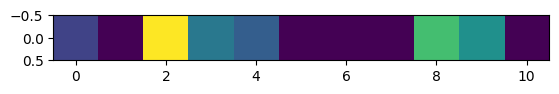

In [789]:
plt.imshow(np.uint8(train_Cap_2s[1][1].reshape(1,11)*10))

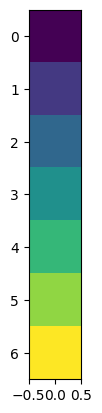

In [848]:
 plt.imshow(np.array([0,1,2,3,4,5,6]).reshape(7,1))

### Kronos 2S Model

Here we develop the new Koronos model, that  takes 3D inputs.

In [183]:
# The inputs are 28x28 RGB images with `channels_last` and the batch
# size is 4. 
from tensorflow.keras.layers import  Conv2D


# baseline model (current Kronos 2.0)

para_epochs = 300
para_early_stop = True
para_model_name = 'base'
para_sea_len = 11
para_sea_dense = 128


batch_size = 100
early_stop = 100
filter_num = 16
rec_act = 'relu'
rec_dropout = 0.1
lstm_size = 128
patience= early_stop
batch_size_nbr = batch_size
Error_Method = 'MC_dropout'
B = batch_size


# Model 
K.clear_session()
input_tensor_closure = Input(shape = (2,7,10))
input_tensor_seas = Input(shape = (para_sea_len))

# # Layer for frac_closure
# cnn_lstm_closure = ConvLSTM1D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
#                               recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_closure)
# cnn_lstm_closure = BatchNormalization(axis = -1)(cnn_lstm_closure)
# cnn_lstm_closure = TimeDistributed(Flatten())(cnn_lstm_closure)
# cnn_lstm_closure = TimeDistributed(Dense(160))(cnn_lstm_closure)

# lets use 2D Conv instead:
cnn_closure = Conv2D( filters = 16, kernel_size =  3,  data_format = "channels_first" , activation='relu', input_shape=input_tensor_closure.shape)(input_tensor_closure)
cnn_closure = Conv2D( filters = 4, kernel_size =  3,  data_format = "channels_first" , activation='relu')(cnn_closure)
cnn_closure = Flatten()(cnn_closure)
cnn_closure = Dense(160)(cnn_closure)
cnn_closure


# layer for seasonality
# cnn_lstm_seas = ConvLSTM1D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
#                               recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_seas)
# cnn_lstm_seas = BatchNormalization(axis = -1)(cnn_lstm_seas)
# cnn_lstm_seas = TimeDistributed(Flatten())(cnn_lstm_seas)
# cnn_lstm_seas = TimeDistributed(Dense(2*para_sea_dense))(cnn_lstm_seas)
# dense_seas = Reshape((2,para_sea_dense))(cnn_lstm_seas)

# Or we can just use a Dense:
dense_seas = Dense(128,activation=rec_act)(input_tensor_seas)
dense_seas = Dense(para_sea_dense,activation=rec_act)(dense_seas)
# dense_seas = Reshape((2,para_sea_dense))(dense_seas)

# concat frac_closure and seasonality
# cnn_lstm = Concatenate()([cnn_lstm_closure, dense_seas])
cnn_lstm = Concatenate()([cnn_closure, dense_seas])
cnn_lstm = LSTM(lstm_size, return_sequences = True)(cnn_lstm)

# output format
output_tensor = TimeDistributed(Dense(70, activation = 'relu'))(cnn_lstm)
output_tensor = Reshape((2, 7, 10))(output_tensor)

# # Kronos model setting
Kronos_model = Model(inputs = [input_tensor_closure, input_tensor_seas], outputs = output_tensor)
Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 288)

In [181]:
cnn_closure

<KerasTensor: shape=(None, 160) dtype=float32 (created by layer 'dense')>

In [96]:
Kronos_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 7, 10)]   0           []                               
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (None, 2, 16, 10)    3008        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1, 11)]   0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 2, 16, 10)   40          ['conv_lstm1d[0][0]']            
 alization)                                                                                   

In [118]:
# Kronos Model
import os
from keras import backend as K 
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import ConvLSTM1D, Reshape , TimeDistributed, BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import random


def Kronos_2S_Model(para_epochs, para_early_stop, para_model_name, para_sea_len, para_sea_dense, train_list, val_list, test_list):
        
    # Set Random Seed 
    seed_value = 44
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    
    # extract train/val/test datasets
    train_fc, train_sea, train_traf = train_list[0], train_list[1], train_list[2]
    val_fc, val_sea, val_traf = val_list[0], val_list[1], val_list[2]
    test_fc, test_sea = test_list[0], test_list[1]
    
    # Model Parameters:
    batch_size = 100
    early_stop = 100
    filter_num = 16
    rec_act = 'relu'
    rec_dropout = 0.1
    lstm_size = 128
    patience= early_stop
    batch_size_nbr = batch_size
    Error_Method = 'MC_dropout'
    B = batch_size


    # Model 
    K.clear_session()
    input_tensor_closure = Input(shape = (2,7,10))
    input_tensor_seas = Input(shape = (1,1,para_sea_len))

    # Layer for frac_closure
    cnn_lstm_closure = ConvLSTM1D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_closure)
    cnn_lstm_closure = BatchNormalization(axis = -1)(cnn_lstm_closure)
    cnn_lstm_closure = TimeDistributed(Flatten())(cnn_lstm_closure)
    cnn_lstm_closure = TimeDistributed(Dense(160))(cnn_lstm_closure)

    # layer for seasonality
    cnn_lstm_seas = ConvLSTM1D(filters = filter_num , kernel_size = 2, strides = (1), padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, return_sequences = True)(input_tensor_seas)
    cnn_lstm_seas = BatchNormalization(axis = -1)(cnn_lstm_seas)
    cnn_lstm_seas = TimeDistributed(Flatten())(cnn_lstm_seas)
    cnn_lstm_seas = TimeDistributed(Dense(2*para_sea_dense))(cnn_lstm_seas)
    dense_seas = Reshape((2,para_sea_dense))(cnn_lstm_seas)

    # Or we can just use a Dense:
    # dense_seas = Dense(128,activation=rec_act)(input_tensor_seas)
    # dense_seas = Dense(2*para_sea_dense,activation=rec_act)(dense_seas)
    # dense_seas = Reshape((2,para_sea_dense))(dense_seas)

    # concat frac_closure and seasonality
    cnn_lstm = Concatenate()([cnn_lstm_closure, dense_seas])
    cnn_lstm = LSTM(lstm_size, input_shape = [1,160+para_sea_dense], return_sequences = True)(cnn_lstm)

    # output format
    output_tensor = TimeDistributed(Dense(70, activation = 'relu'))(cnn_lstm)
    output_tensor = Reshape((2, 7, 10))(output_tensor)

    # # Kronos model setting
    Kronos_model = Model(inputs = [input_tensor_closure, input_tensor_seas], outputs = output_tensor)
    Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    if para_early_stop: # with early stop
        
        os.chdir(r"\\corpaa.aa.com\campusshared\HDQ\HDQ_REVMGMT_Share\RMDEPT")
        path = "BFox/Kronos/Prototype/Output/FullPeriod/"
        market_nm = orig + dest
        # if not os.path.exists(path):
            # os.mkdir(path)
        
        history = History()
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)
        mc = ModelCheckpoint(path + '//' + market_nm + '_' + 'best_model.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True, period=1)
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0, callbacks=[history,es,mc])
    else: # no early stop
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0)
         
    
    # use the trained model to predict
    test_pred = Kronos_model.predict([test_fc, test_sea])

    # copy of train/test/val dataset to store prediction results
    test_df = Data_POST.copy()
    
     
    # test set
    cls = {k:[] for k in range(1,11)}
    for i,plane in enumerate(test_pred):
        for j,row in enumerate(plane):
            for k,col in enumerate(row):
                for idx in range(1,11):
                    cls[idx].append(col[idx-1])
    # append to the val dataset
    for idx in range(1,11):
        test_df[f'pred{idx}'] = cls[idx]  
    test_df['dataset'] = 'test'
    test_df['model'] = para_model_name
    
    
    # append all results below (col num stay the same)
    all_test = test_df
    
    
    # calculate mean/std/MSE
    all_test['yr'] = all_test['flightDepartureDate'].dt.year
    all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

    # actual traffic
    all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
    all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
    all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
    all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
    # all predictions
    all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
    all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
    all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
    all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
    # all FvT errors
    all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
    all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
    all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
    all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
    # squared FvT errors for MSE
    all_test['top_FvT_sqr'] = all_test['top_FvT']**2
    all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
    all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
    all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2
    
    all_test = all_test[ (all_test['real']==1)]
    

    return all_test, base_hist, Kronos_model


### Model Training:

In [123]:

# # baseline model (current Kronos 2.0)

# ret_base, base_hist, model_base = Kronos_2S_Model(para_epochs = 300, para_early_stop =  True, para_model_name = 'base', para_sea_len = sea_len, para_sea_dense =  4,
#              train_list = train_base_2s , val_list = val_base_2s, test_list = test_base_2s)

# # para model (current Kronos 2.0 with hyperparameter changes)
# ret_para, para_hist , model_para = Kronos_2S_Model(para_epochs = 300, para_early_stop =  True, para_model_name = 'para', para_sea_len = sea_len, para_sea_dense =  160,
#             train_list = train_base_2s , val_list = val_base_2s, test_list = test_base_2s)

# para_Cap (hyperparameter changes + new features)
ret_para_Cap, ret_para_Cap_hist,  model_ret_para = Kronos_2S_Model(para_epochs = 300, para_early_stop =  True, para_model_name = 'para_cap', para_sea_len = sea_len_Cap, para_sea_dense =  160,
             train_list = train_Cap_2s , val_list = val_Cap_2s, test_list = test_Cap_2s)
    
    
# save all returned results
ret_df = ret_base
ret_df = ret_df.append(ret_para)
ret_df = ret_df.append(ret_para_Cap)


9/9 [==============================] - 2s 9ms/step


C:\Users\250318\AppData\Local\Temp\1\ipykernel_5036\3219902000.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ret_df = ret_df.append(ret_para)
C:\Users\250318\AppData\Local\Temp\1\ipykernel_5036\3219902000.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ret_df = ret_df.append(ret_para_Cap)


In [187]:
train_Cap_2s[0].shape

(582, 2, 7, 10)

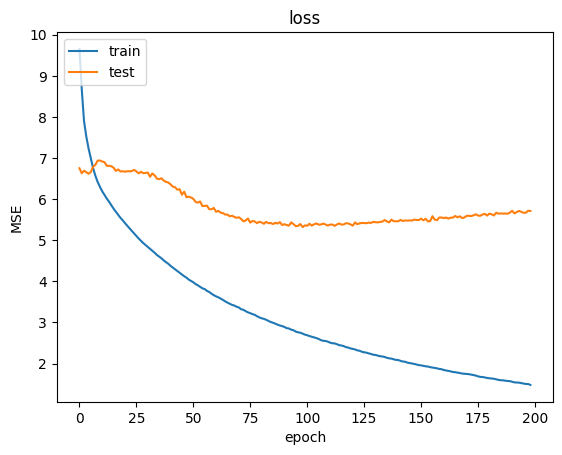

In [120]:
plt.plot(ret_para_Cap_hist.history['loss'])
plt.plot(ret_para_Cap_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val' , loc = "upper left")
plt.show()

In [117]:
# top/mid/bot/sum - FvT mean/std/MSE 
print('baseline')
print([ret_base['top_FvT'].mean(), ret_base['top_FvT'].std(), ret_base['top_FvT_sqr'].mean()])
print([ret_base['mid_FvT'].mean(), ret_base['mid_FvT'].std(), ret_base['mid_FvT_sqr'].mean()])
print([ret_base['bot_FvT'].mean(), ret_base['bot_FvT'].std(), ret_base['bot_FvT_sqr'].mean()])
print([ret_base['sum_FvT'].mean(), ret_base['sum_FvT'].std(), ret_base['sum_FvT_sqr'].mean()])

# top/mid/bot/sum - FvT mean/std/MSE
print('para')
print([ret_para['top_FvT'].mean(), ret_para['top_FvT'].std(), ret_para['top_FvT_sqr'].mean()])
print([ret_para['mid_FvT'].mean(), ret_para['mid_FvT'].std(), ret_para['mid_FvT_sqr'].mean()])
print([ret_para['bot_FvT'].mean(), ret_para['bot_FvT'].std(), ret_para['bot_FvT_sqr'].mean()])
print([ret_para['sum_FvT'].mean(), ret_para['sum_FvT'].std(), ret_para['sum_FvT_sqr'].mean()])


# top/mid/bot/sum - FvT mean/std/MSE
print('para_Cap')
print([ret_para_Cap['top_FvT'].mean(), ret_para_Cap['top_FvT'].std(), ret_para_Cap['top_FvT_sqr'].mean()])
print([ret_para_Cap['mid_FvT'].mean(), ret_para_Cap['mid_FvT'].std(), ret_para_Cap['mid_FvT_sqr'].mean()])
print([ret_para_Cap['bot_FvT'].mean(), ret_para_Cap['bot_FvT'].std(), ret_para_Cap['bot_FvT_sqr'].mean()])
print([ret_para_Cap['sum_FvT'].mean(), ret_para_Cap['sum_FvT'].std(), ret_para_Cap['sum_FvT_sqr'].mean()])


baseline
[-0.7115635829019656, 3.6259239995696304, 13.650021735166574]
[-0.5174616437132578, 5.308639081763963, 28.441643349202305]
[-0.1798840141960487, 6.862612656489692, 47.11482246558764]
[-1.4089092542142523, 9.085022589740646, 84.49989801919594]
para
[-0.6583615128274275, 3.6325904842719763, 13.625514315048564]
[-0.33347252140415473, 5.493692116591673, 30.28353359314469]
[-0.04720774325989063, 6.881832396158363, 47.34878458093915]
[-1.039041779733094, 8.974881893654064, 81.6058986758689]
para_Cap
[-0.6440714799759985, 3.7530291449117, 14.496171325391241]
[-0.1998468000745895, 5.426652001046287, 29.480369185906646]
[0.9561781223654805, 7.492183876814723, 57.03161520056215]
[0.11225983774380927, 9.194325150623028, 84.52490350827713]


In [110]:
# top/mid/bot/sum - FvT mean/std/MSE 
print('baseline')
print([ret_base['top_FvT'].mean(), ret_base['top_FvT'].std(), ret_base['top_FvT_sqr'].mean()])
print([ret_base['mid_FvT'].mean(), ret_base['mid_FvT'].std(), ret_base['mid_FvT_sqr'].mean()])
print([ret_base['bot_FvT'].mean(), ret_base['bot_FvT'].std(), ret_base['bot_FvT_sqr'].mean()])
print([ret_base['sum_FvT'].mean(), ret_base['sum_FvT'].std(), ret_base['sum_FvT_sqr'].mean()])



baseline
[-0.6983088080653632, 3.5842921639095, 13.331242443615139]
[-0.7572207325567084, 5.701813993840629, 33.075100067321024]
[0.19777866643550407, 7.198469928471746, 51.84279504203905]
[-1.2577508843061604, 9.439887685649424, 90.66884110704304]


In [111]:
# top/mid/bot/sum - FvT mean/std/MSE
print('para')
print([ret_para['top_FvT'].mean(), ret_para['top_FvT'].std(), ret_para['top_FvT_sqr'].mean()])
print([ret_para['mid_FvT'].mean(), ret_para['mid_FvT'].std(), ret_para['mid_FvT_sqr'].mean()])
print([ret_para['bot_FvT'].mean(), ret_para['bot_FvT'].std(), ret_para['bot_FvT_sqr'].mean()])
print([ret_para['sum_FvT'].mean(), ret_para['sum_FvT'].std(), ret_para['sum_FvT_sqr'].mean()])

para
[-0.6682425129427166, 3.6344654149873836, 13.652243958249718]
[-0.7678699017822397, 5.363171201366211, 29.34529692185157]
[-0.15006289808557333, 6.892505931741957, 47.516055227278834]
[-1.5861753129959724, 9.188682346536249, 86.92455025858476]


In [112]:
# top/mid/bot/sum - FvT mean/std/MSE
print('para_Cap')
print([ret_para_Cap['top_FvT'].mean(), ret_para_Cap['top_FvT'].std(), ret_para_Cap['top_FvT_sqr'].mean()])
print([ret_para_Cap['mid_FvT'].mean(), ret_para_Cap['mid_FvT'].std(), ret_para_Cap['mid_FvT_sqr'].mean()])
print([ret_para_Cap['bot_FvT'].mean(), ret_para_Cap['bot_FvT'].std(), ret_para_Cap['bot_FvT_sqr'].mean()])
print([ret_para_Cap['sum_FvT'].mean(), ret_para_Cap['sum_FvT'].std(), ret_para_Cap['sum_FvT_sqr'].mean()])


para_Cap
[-0.7883410957087498, 3.87694893874109, 15.64806949118673]
[-0.9656659817429423, 6.114127236315188, 38.30475306607013]
[0.3478581535096203, 7.159740287158982, 51.36874896593161]
[-1.4061489245788565, 9.56714273271316, 93.48223211383753]


# Kronos 3S Development

This Version, several things will be focused on:

1. Redefining the model in way that is works as a timeseries, with a given window as an hyperparameter. 
    - Redefine the data input.
        - Check how using DOW FCST on the time series performs compared to every day one, and add it as an hyperparameter.
    - Redesign the data structure.
        - Add three diffrent Forecast Closure for prediction baed on privious FC: (I should figure out a function for that)
            1. Exact - Use the exact FC for the training.
            2. Low - Based on the privious one, low meaning if we use lower fairs
            3. Mid - Mid is we use average fair opening.
            4. HIgh FC rate -> Meaning if we use higher fairs
            
2. Add the MASKING sterategy.
3. Move from FC to Terrafic (Compare FC, Terrafic, FC+Terrafic Models)
4. Train all the FCST's together, and add FCST as Seasenality input. 
5. Train all the markets together, and give the Origin, and Dest and inputs. 


New goals:
1. Build a time series, given a FC, and privious trrafic  predict FC.
    - Randomly define a "today" date for each trrafic. (from now to 365 days from now)
    - Find the `WIDNOW` size before that date.
    - USE DOW for the time-series.
    
    

## 1st Iter: FC Time-series

In this iteration, I worked on formating the Kronos model into atimeseries.

The results show that the privious FC might not be that representative of the current Trrafic.

### Redefining the data:

Here we want to create time-series data, given an input window.

#### Set HyperParameters:

In [138]:
window = 5

USE_DOW = False

next_year_today = datetime.today() + timedelta(days=365)
yesterday =  datetime.today() - timedelta(days=30) # CHANGE BACK TO 1 WHEN LOADING NEW DATA

# Pre Covid:
Pre_start, Pre_end = '2017-09-01', '2020-01-30'

# Post Covid till yesterday:
Post_start, Post_end = '2021-07-01', yesterday.strftime("%Y-%m-%d")

# Today till one year in future:
future_start , future_end = datetime.today().strftime("%Y-%m-%d") ,   next_year_today.strftime("%Y-%m-%d")



#### Group, sort, and pad:

- Here we first group the values together (the 14 row),
- Then sort them based on the flight-date, and booking period.
- Pad if any data is missing.

In [139]:
# HEre we group by and sort the values so each 14 value represent a single data point on a day.

groupbyColumns = ['snapshotDate','origin','destination','forecastId','flightDepartureDate',
                  'forecastDayOfWeek','poolCode','cabinCode']
grouped = df[df['flightDepartureDate'] <= future_end].groupby(groupbyColumns)

merged_list = []
count_rows_misskey = 0
for g in grouped:
    
    # g[0] is the directory key and g[1] is the value (actual data)
    # identify the cells of g[1] that not in fullKeys
    # g[1][~g[1].isin(fullKeys)] 
    
    # identify the missing keys in g[1]
    key = g[1][['localFlowIndicator','forecastPeriod']]
    missingKeys = fullKeys[~fullKeys[['localFlowIndicator','forecastPeriod']].apply(tuple,1).isin(key.apply(tuple,1))]
    count_rows_misskey += missingKeys.shape[0]
    
    # append the missing keys under the data
    fullHistory = pd.concat([g[1],missingKeys])
    
    # use 0 to indicate padding data
    fullHistory['real'].fillna(0, inplace=True) 
    
    # fill the data with missing keys
    fullHistory = fullHistory.fillna(method='ffill')
    merged_list.append(fullHistory)
    
# merge all data across 'flightDepartureDate'   
out = pd.concat(merged_list)
out = out.sort_values(['snapshotDate','origin','destination',
                            'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                             'cabinCode','localFlowIndicator'])



In [140]:
# And if there is any misssing value we'll use padding:

# Get full history and then concat fake history (padding) from above 
post = out.copy()
post = post.sort_values(['snapshotDate','origin','destination',
                            'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                             'cabinCode','localFlowIndicator'])


post['groupID'] = (post.groupby(['snapshotDate','origin','destination',
                            'forecastId','flightDepartureDate','forecastDayOfWeek','poolCode',
                             'cabinCode']).cumcount()==0).astype(int)
post['groupID'] = post['groupID'].cumsum()
# Full Hisotyr Pre Fixing
post['fullHistory'] = post.groupby(['groupID'])["forecastPeriod"].transform("count")

post['flightDepartureDate'] = pd.to_datetime(post['flightDepartureDate'], format='%Y/%m/%d')

post

,snapshotDate,origin,destination,forecastId,forecastDepartureDate,forecastDayOfWeek,poolCode,cabinCode,forecastPeriod,localFlowIndicator,flightDepartureDate,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All,groupID,fullHistory,real
0,2022-10-17,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,1.0,F,2017-09-03,0.0,0.0,0.0,0.004,0.015,0.029,0.029,0.029,0.033,0.117,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.36,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1.0
1,2022-10-17,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,2.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.015,0.029,0.029,0.455,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.36,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1.0
2,2022-10-17,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,3.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.044,0.662,0.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.36,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1.0
3,2022-10-17,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,4.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.000,0.005,0.070,0.987,1.000,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.36,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1.0
4,2022-10-17,SEA,DFW,7.0,2017-09-03,7.0,HL,Y,5.0,F,2017-09-03,0.0,0.0,0.0,0.000,0.000,0.004,0.075,0.735,1.000,1.000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.234948,0.075404,0.809,0.098,0.221,0.16,0.296,0.36,1.0,1.0,2017-09-03,886.0,995.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.791753,0.476852,0.0,0.700384,0.777778,0.50,0.0,0.692308,0.791753,0.700384,1,14,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,2022-10-17,SEA,DFW,7.0,2023-03-15,3.0,M,Y,2.0,L,2023-03-15,1.0,1.0,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.000,0.000,0.00,0.000,0.00,0.0,0.0,2023-03-15,886.0,995.0,0.131313,0.0,

In [141]:
# Pre: pre-covid period, used for train and validation
# Post: post-covid period, used for test

# Cut the 'post' data into Pre-covid and Post-covid parts
Data_PRE = post[ (post['flightDepartureDate']>=Pre_start) & (post['flightDepartureDate']<=Pre_end) ]
Data_POST = post[ (post['flightDepartureDate']>=Post_start) & (post['flightDepartureDate']<=Post_end) ]
Data_FUTURE = post[ (post['flightDepartureDate']>=future_start) & (post['flightDepartureDate']<=future_end) ]

print(Data_PRE.shape)
print(Data_POST.shape)
print(Data_FUTURE.shape)

(10178, 83)
(4690, 83)
(1470, 83)


#### Get the tensors:

The output shape depends on what you ask the function.

- time_series: If `True` we use the given `window` to go back in history for each datapoint. -> For now we will get the `window` size privious FC, and Seasenality, and current Traffic (as ouput)
- use_channels: if `True`, the flow vs local flow is used as channels (2 channels)
- test: if test `True` the function would not return Traffic.
- dow_get_tensors: This function will allows us to extract privious data based on day of week (vs daily)

**NOTE**: when using the time series, since the first `window` size data would not have output, they would not be used as training data, meaning the training data will be `window` size smaller. If we use the `dow_get_tensors` since we would not have the `window` size for each of the day, we will have `window`x`len(dow)` less data.

Output Shapes:

time_series: `True`,  use_channel: `True`: 
- FC: `(Training_samples, window (time) , channels, rows, cols)` : (len(sample), widnow, 2, 7, 10)
- Seasenality: `(Training_sample, window (time) , values)`:  (len(sample), widnow, 11)
- Terrafic: `(Training_samples, channels, rows, cols)`:  (len(sample), 2, 7, 10)






In [146]:
def get_tensors(DataFarame, test = False, time_series = True , use_channels = False  ,  window = 10):
    
    sea_col_Cap = ['week_x', 'week_y','dow_x', 'dow_y', 'avgrasm','seats_AA_fcst','seats_OA_fcst','seats_ulcc_fcst' , 'seats_AA' , 'seats_OA' , 'seats_ulcc']
    len_sea_cap = len(sea_col_Cap)
            
    
    # fractional closure
    PRE_FC_L = DataFarame[['fracClosure_' + str(i + 1) for i in range(10)]].values.astype('float32')
    # seasonality
    PRE_Sea_L = DataFarame[sea_col_Cap].values.astype('float32')
    # actual traffic
    if test:
        Traffic = False
    else:
        PRE_Traf_L = DataFarame[['trafficActual_' + str(i + 1) for i in range(10)]].values.astype('float32')
    
    
    # reshape the data for CNNLSTM model
    FC = PRE_FC_L.reshape(int(PRE_FC_L.shape[0]/14), 1, 14, 10)
    Seasenality = PRE_Sea_L.reshape(int(PRE_Sea_L.shape[0]/14), 1,14, len_sea_cap)
    
    # Remove Duplicates (from 2d to 1d vector)
    Seasenality_oneV =np.delete(Seasenality, slice(13), 2).reshape(Seasenality.shape[0],len_sea_cap)
    
    if not test:
        Traffic = PRE_Traf_L.reshape(int(PRE_Traf_L.shape[0]/14), 1, 14, 10)
    
    
    if use_channels:
        FC = FC.reshape(len(FC),2,7,10)
        if not test:
            Traffic = Traffic.reshape(len(Traffic),2,7,10)
    
    # Change FC shape to refelect time series:
    # print(FC.shape)
    if time_series:
        time_series_widow= list()
        Seasenality_times = list()
        for i in range(window,len(FC)):
            # print(FC[i-window:i].shape)
            time_series_widow.append(FC[i-window:i].reshape(window,2,7,10))
            # print((Seasenality_oneV[i-window:i].shape))
            Seasenality_times.append(Seasenality_oneV[i-window:i])
        FC = np.array(time_series_widow)
        Seasenality_oneV = np.array(Seasenality_times)
        
        # Since the 1st window size data points are removed:
        # Seasenality_oneV = Seasenality_oneV[window:]
        if not test:
            Traffic = Traffic[window:]
        
        
    return FC, Seasenality_oneV, Traffic


def dow_get_tensors(DataFarame ,  test = False, time_series = True,  use_channels = False , window = 10):   
    FC_dow , Seasenality_dow, Traffic_dow = list(), list(), list()
    
    for i in DataFarame.loc[ :,	['dow_x' ,	'dow_y' ]].drop_duplicates().values:
        filter_y = DataFarame['dow_y' ] == i[1] 
        filter_x = DataFarame['dow_x'] == i[0] 
        # print(filter_y.shape , filter_x.shape)
        print(i)
        Data_dow =DataFarame[filter_x & filter_y]
        print(Data_dow.shape)
        FC, Seasenality, Traffic = get_tensors(Data_dow, test, time_series , use_channels , window )
        FC_dow.append(FC)
        Seasenality_dow.append(Seasenality)
        Traffic_dow.append(Traffic)
    
    # Then Concat together, now each datapoint is based on DOW.
    FC_dow = [ i  for i in FC_dow if i.shape!=(0,)]
    Seasenality_dow = [ i  for i in Seasenality_dow if i.shape!=(0,)]
    
    
    FC_dow = np.concatenate(FC_dow)
    Seasenality_dow = np.concatenate(Seasenality_dow)
    if test:
        Traffic_dow = False
    else:
        Traffic_dow = [ i  for i in Traffic_dow if i.shape!=(0,)]
        Traffic_dow = np.concatenate(Traffic_dow)
    
    return FC_dow , Seasenality_dow, Traffic_dow 

In [474]:
# OLDER VERSIOn (FC-timeseries)

PRE_FC_3S , PRE_Seas_3S , PRE_Traf_3S  = get_tensors(Data_PRE,  test = False, time_series = True, use_channels = True , window =window)
POST_FC_3S , POST_Seas_3S , _  = get_tensors(Data_POST,  test = True, time_series = True, use_channels = True , window = window )
FUTURE_FC_3S , FUTURE_Seas_3S , _  = get_tensors(Data_FUTURE,  test = True, time_series = True, use_channels = True , window = window)

## *********** NEEDS TO BE CHECKED *********** : I think the given DOW is wrong for the fake data point CHECK

PRE_FC_DOW_3S , PRE_Seas_DOW_3S , PRE_Traf_DOW_3S  = dow_get_tensors(Data_PRE, test = False, time_series = True,  use_channels = True , window = window)
POST_FC_DOW_3S , POST_Seas_DOW_3S , _  = dow_get_tensors(Data_POST , time_series = True, use_channels = True , window = window)
# FUTURE_FC_DOW_3S , FUTURE_Seas_DOW_3S , _  = dow_get_tensors(Data_FUTURE,  test = True, time_series = True, use_channels = True , window = 10)


print(PRE_FC_DOW_3S.shape , PRE_Seas_DOW_3S.shape , PRE_Traf_DOW_3S.shape)
print(POST_FC_DOW_3S.shape , POST_Seas_DOW_3S.shape )
# print(FUTURE_FC_DOW_3S.shape , FUTURE_Seas_DOW_3S.shape )


In [52]:
# Kronos input with new features (With Cap data)

# 80, 20 --> 
# TODO: THIS SHOULD BE CHANGED TO RANDOMIZED.
train_test_cutoff = round(PRE_FC_3S.shape[0]*0.9) 


# prepare train/val/test datasets
PRE_FC_3S_train = PRE_FC_3S[:train_test_cutoff, :]
PRE_FC_3S_val = PRE_FC_3S[train_test_cutoff:, :]

PRE_Seas_3S_train = PRE_Seas_3S[:train_test_cutoff, :]
PRE_Seas_3S_val = PRE_Seas_3S[train_test_cutoff:, :]

PRE_Traf_3S_train = PRE_Traf_3S[:train_test_cutoff, :]
PRE_Traf_3S_val = PRE_Traf_3S[train_test_cutoff:, :]



train_3s = [PRE_FC_3S_train,PRE_Seas_3S_train,PRE_Traf_3S_train]
val_3s = [PRE_FC_3S_val,PRE_Seas_3S_val,PRE_Traf_3S_val]
test_3s = [POST_FC_3S,POST_Seas_3S]


In [53]:
Data_FUTURE.iloc[-14:-1]

,snapshotDate,origin,destination,forecastId,forecastDepartureDate,forecastDayOfWeek,poolCode,cabinCode,forecastPeriod,localFlowIndicator,flightDepartureDate,fracClosure_1,fracClosure_2,fracClosure_3,fracClosure_4,fracClosure_5,fracClosure_6,fracClosure_7,fracClosure_8,fracClosure_9,fracClosure_10,trafficActual_1,trafficActual_2,trafficActual_3,trafficActual_4,trafficActual_5,trafficActual_6,trafficActual_7,trafficActual_8,trafficActual_9,trafficActual_10,trafficActualAadv_1,trafficActualAadv_2,trafficActualAadv_3,trafficActualAadv_4,trafficActualAadv_5,trafficActualAadv_6,trafficActualAadv_7,trafficActualAadv_8,trafficActualAadv_9,trafficActualAadv_10,holiday,H1,H2,H3,HL,weekNumber,week_x,week_y,dow_x,dow_y,avgtraffic,avgtrafficopenness,avgrasm,dowavgtraffic,dowavgtrafficopenness,dowavgrasm,groupID,fullHistory,real,adj_dep_date,fcst_start,fcst_end,seats_AA_fcst,seats_OA_fcst,seats_ulcc_fcst,seats_All_fcst,flt_ct_AA_fcst,flt_ct_OA_fcst,flt_ct_ulcc_fcst,flt_ct_All_fcst,asm_AA_fcst,asm_All_fcst,seats_AA,seats_OA,seats_ulcc,seats_All,flt_ct_AA,flt_ct_OA,flt_ct_ulcc,flt_ct_All,asm_AA,asm_All
16422,2022-10-13,SEA,DFW,7.0,2023-03-11,6.0,M,Y,7.0,F,2023-03-11,0.0,0.163,0.163,0.163,0.163,0.163,0.163,0.163,0.163,0.163,0.0,0.0,0.0,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.704067,0.956473,0.381,0.0,0.825,0.707,0.417,1.0,0.963,0.465,1240,14,1.0,2023-03-11,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.492784,0.75,0.0,0.576702,0.444444,0.75,0.0,0.538462,0.492784,0.576702
0,2022-10-13,SEA,DFW,7.0,2023-03-11,6.0,M,Y,1.0,F,2023-03-11,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,1240,14,0.0,2023-03-11,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.492784,0.75,0.0,0.576702,0.444444,0.75,0.0,0.538462,0.492784,0.576702
1,2022-10-13,SEA,DFW,7.0,2023-03-11,6.0,M,Y,2.0,F,2023-03-11,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,1240,14,0.0,2023-03-11,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.492784,0.75,0.0,0.576702,0.444444,0.75,0.0,0.538462,0.492784,0.576702
2,2022-10-13,SEA,DFW,7.0,2023-03-11,6.0,M,Y,3.0,F,2023-03-11,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,1240,14,0.0,2023-03-11,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.492784,0.75,0.0,0.576702,0.444444,0.75,0.0,0.538462,0.492784,0.576702
3,2022-10-13,SEA,DFW,7.0,2023-03-11,6.0,M,Y,4.0,F,2023-03-11,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,1240,14,0.0,2023-03-11,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.492784,0.75,0.0,0.576702,0.444444,0.75,0.0,0.538462,0.492784,0.576702
4,2022-10-13,SEA,DFW,7.0,2023-03-11,6.0,M,Y,5.0,F,2023-03-11,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,1240,14,0.0,2023-03-11,886.0,995.0,0.131313,0.0,0.0,0.131313,0.0,0.0,0.0,0.0,0.131313,0.131313,0.492784,0.75,0.0,0.576702,0.444444,0.75,0.0,0.538462,0.492784,0.576702
5,2022-10-13,SEA,DFW,7.0,2023-03-11,6.0,M,Y,6.0,F,2023-03-11,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [54]:
Data_FUTURE.iloc[0:14,21:31].sum().sum()

165.0

In [55]:
Data_POST.iloc[-114:-100,21:31].sum().sum()

174.0

### Kronos 3.1S Model:

Lets now build the Kronos 3S initial version.

For now: Given Time-series FC, predict curent Trrafic.

In [56]:
import os
from keras import backend as K 
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import ConvLSTM2D, Reshape , TimeDistributed, BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten, Conv2D, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import random


# baseline model (current Kronos 2.0)

para_epochs = 300
para_early_stop = True
para_model_name = 'base'
para_sea_len = 11
para_sea_dense = 128


batch_size = 100
early_stop = 100
filter_num = 16
rec_act = 'relu'
rec_dropout = 0.1
dropout = 0.1
lstm_size = 128
patience= early_stop
batch_size_nbr = batch_size
Error_Method = 'MC_dropout'
B = batch_size


# Model 
K.clear_session()
input_tensor_closure = Input(shape = (window , 2,7,10))
input_tensor_seas = Input(shape = (window ,para_sea_len))

# Lets use 2d CNNLSTM for now:
cnn_lstm_closure = Bidirectional(ConvLSTM2D(filters = filter_num , kernel_size = 3, padding = 'same', data_format = 'channels_first', 
                              recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = True))(input_tensor_closure)
cnn_lstm_closure = Bidirectional(ConvLSTM2D(filters = filter_num//4 , kernel_size = 2, padding = 'same', data_format = 'channels_first', 
                              recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = False))(cnn_lstm_closure)
cnn_lstm_closure = BatchNormalization(axis = 1)(cnn_lstm_closure)
# Now Flatten and feed to a FF newtork:
cnn_lstm_closure = Flatten()(cnn_lstm_closure)
cnn_lstm_closure = Dense(128, activation=rec_act)(cnn_lstm_closure)

print(cnn_lstm_closure)


# layer for seasonality Using a RNN (Here GRU instead of LSTM)
rnn_seas = Bidirectional(GRU(lstm_size, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = True  ))(input_tensor_seas)
rnn_seas = Bidirectional(GRU(lstm_size//2, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = False ))(rnn_seas)
rnn_seas = BatchNormalization()(rnn_seas)
rnn_seas = Dense(32, activation=rec_act)(rnn_seas)


print(rnn_seas)


# concat frac_closure and seasonality
FF_seas_closure = Concatenate()([cnn_lstm_closure, rnn_seas])
FF_seas_closure = Dense(256, activation=rec_act)(FF_seas_closure)
FF_seas_closure = Dense(140, activation=rec_act)(FF_seas_closure)

# Output format:
output_tensor = Reshape((2, 7, 10))(FF_seas_closure)

print(output_tensor)


# # # Kronos model setting
Kronos_model = Model(inputs = [input_tensor_closure, input_tensor_seas], outputs = output_tensor)
Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='dense/Relu:0', description="created by layer 'dense'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='dense_1/Relu:0', description="created by layer 'dense_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 7, 10), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")


In [57]:
Kronos_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 2, 7, 10  0           []                               
                                )]                                                                
                                                                                                  
 bidirectional (Bidirectional)  (None, 5, 16, 7, 20  20864       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 5, 11)]      0           []                               
                                                                                              

In [58]:
# Kronos Model
import os
from keras import backend as K 
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import ConvLSTM2D, Reshape , TimeDistributed, BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten, Conv2D, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import random


def Kronos_3S_Model(para_epochs, para_early_stop, para_model_name, para_sea_len, para_sea_dense, window ,  train_list, val_list, test_list):
        
    batch_size = 256
    early_stop = 50
    filter_num = 16
    rec_act = 'relu'
    rec_dropout = 0.1
    dropout = 0.1
    lstm_size = 128
    patience= early_stop
    batch_size_nbr = batch_size
    Error_Method = 'MC_dropout'
    B = batch_size

    
    # Set Random Seed 
    seed_value = 44
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    
    # extract train/val/test datasets
    train_fc, train_sea, train_traf = train_list[0], train_list[1], train_list[2]
    val_fc, val_sea, val_traf = val_list[0], val_list[1], val_list[2]
    test_fc, test_sea = test_list[0], test_list[1]

    # ************* MODEL ************* 
    K.clear_session()
    input_tensor_closure = Input(shape = (window , 2,7,10))
    input_tensor_seas = Input(shape = (window ,para_sea_len))

    # Lets use 2d CNNLSTM for now:
    cnn_lstm_closure = Bidirectional(ConvLSTM2D(filters = filter_num , kernel_size = 3, padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = False))(input_tensor_closure)
    # cnn_lstm_closure = Bidirectional(ConvLSTM2D(filters = filter_num , kernel_size = 3, padding = 'same', data_format = 'channels_first', 
    #                               recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = True))(input_tensor_closure)
    # cnn_lstm_closure = Bidirectional(ConvLSTM2D(filters = filter_num//4 , kernel_size = 2, padding = 'same', data_format = 'channels_first', 
    #                               recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = False))(cnn_lstm_closure)
    cnn_lstm_closure = BatchNormalization(axis = 1)(cnn_lstm_closure)
    # Now Flatten and feed to a FF newtork:
    cnn_lstm_closure = Flatten()(cnn_lstm_closure)
    cnn_lstm_closure = Dense(128, activation=rec_act)(cnn_lstm_closure)

    # print(cnn_lstm_closure)


    # layer for seasonality Using a RNN (Here GRU instead of LSTM)
    rnn_seas = Bidirectional(GRU(lstm_size, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = False  ))(input_tensor_seas)
    # rnn_seas = Bidirectional(GRU(lstm_size, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = True  ))(input_tensor_seas)
    # rnn_seas = Bidirectional(GRU(lstm_size//2, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = False ))(rnn_seas)
    rnn_seas = BatchNormalization()(rnn_seas)
    rnn_seas = Dense(32, activation=rec_act)(rnn_seas)


    # print(rnn_seas)


    # concat frac_closure and seasonality
    FF_seas_closure = Concatenate()([cnn_lstm_closure, rnn_seas])
    FF_seas_closure = Dense(256, activation=rec_act)(FF_seas_closure)
    FF_seas_closure = Dense(140, activation=rec_act)(FF_seas_closure)

    # Output format:
    output_tensor = Reshape((2, 7, 10))(FF_seas_closure)

    # print(output_tensor)


    # # # Kronos model setting
    Kronos_model = Model(inputs = [input_tensor_closure, input_tensor_seas], outputs = output_tensor)
    Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    if para_early_stop: # with early stop
        
        os.chdir(r"\\corpaa.aa.com\campusshared\HDQ\HDQ_REVMGMT_Share\RMDEPT")
        path = "BFox/Kronos/Prototype/Output/FullPeriod/"
        market_nm = orig + dest
        # if not os.path.exists(path):
            # os.mkdir(path)
        
        history = History()
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)
        mc = ModelCheckpoint(path + '//' + market_nm + '_' + 'best_model.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True, period=1)
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0, callbacks=[history,es,mc])
    else: # no early stop
        base_hist = Kronos_model.fit([train_fc, train_sea], train_traf, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([val_fc, val_sea], val_traf), verbose = 0)
         
    
    # use the trained model to predict
    test_pred = Kronos_model.predict([test_fc, test_sea])


    return test_pred, base_hist, Kronos_model

#     # copy of train/test/val dataset to store prediction results
#     test_df = Data_POST.copy()
#     # test set
#     cls = {k:[] for k in range(1,11)}
#     for i,plane in enumerate(test_pred):
#         for j,row in enumerate(plane):
#             for k,col in enumerate(row):
#                 for idx in range(1,11):
#                     cls[idx].append(col[idx-1])
#     # append to the val dataset
#     for idx in range(1,11):
#         test_df[f'pred{idx}'] = cls[idx]  
#     test_df['dataset'] = 'test'
#     test_df['model'] = para_model_name
    
    
#     # append all results below (col num stay the same)
#     all_test = test_df
    
    
#     # calculate mean/std/MSE
#     all_test['yr'] = all_test['flightDepartureDate'].dt.year
#     all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

#     # actual traffic
#     all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
#     all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
#     all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
#     all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
#     # all predictions
#     all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
#     all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
#     all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
#     all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
#     # all FvT errors
#     all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
#     all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
#     all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
#     all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
#     # squared FvT errors for MSE
#     all_test['top_FvT_sqr'] = all_test['top_FvT']**2
#     all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
#     all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
#     all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2
    
#     all_test = all_test[ (all_test['real']==1)]
    

#    return all_test, base_hist, Kronos_model


In [59]:
kronos3s_test_results , kronos3s_hist,  kronos3s_model = Kronos_3S_Model(para_epochs = 100, para_early_stop =  True, para_model_name = 'kronos3s', para_sea_len = sea_len_Cap, para_sea_dense =  160, window = window ,
             train_list = train_3s , val_list = val_3s, test_list = test_3s)
    


11/11 [==============================] - 2s 37ms/step


#### Results:


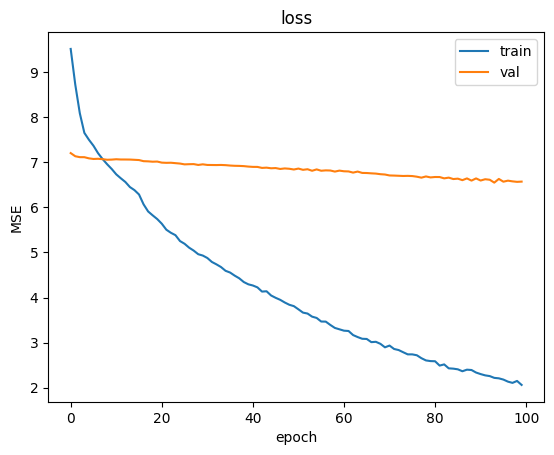

In [61]:
plt.plot(kronos3s_hist.history['loss'])
plt.plot(kronos3s_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val'] , loc = "upper right")
plt.show()

In [62]:
test_df = Data_POST[window*14:].copy()

# test set
cls = {k:[] for k in range(1,11)}
for i,plane in enumerate(kronos3s_test_results):
    for j,row in enumerate(plane):
        for k,col in enumerate(row):
            for idx in range(1,11):
                cls[idx].append(col[idx-1])
# append to the val dataset
for idx in range(1,11):
    test_df[f'pred{idx}'] = cls[idx]  
test_df['dataset'] = 'test'
test_df['model'] = para_model_name


# append all results below (col num stay the same)
all_test = test_df


# calculate mean/std/MSE
all_test['yr'] = all_test['flightDepartureDate'].dt.year
all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

# actual traffic
all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
# all predictions
all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
# all FvT errors
all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
# squared FvT errors for MSE
all_test['top_FvT_sqr'] = all_test['top_FvT']**2
all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2

all_test = all_test[ (all_test['real']==1)]

In [63]:
# top/mid/bot/sum - FvT mean/std/MSE
print('Kronos_3s')
print([all_test['top_FvT'].mean(), all_test['top_FvT'].std(), all_test['top_FvT_sqr'].mean()])
print([all_test['mid_FvT'].mean(), all_test['mid_FvT'].std(), all_test['mid_FvT_sqr'].mean()])
print([all_test['bot_FvT'].mean(), all_test['bot_FvT'].std(), all_test['bot_FvT_sqr'].mean()])
print([all_test['sum_FvT'].mean(), all_test['sum_FvT'].std(), all_test['sum_FvT_sqr'].mean()])

Kronos_3s
[-1.6442650773569225, 4.527951069994132, 23.201456350002722]
[-2.6296079669120282, 6.325158910393339, 46.91370738655476]
[-2.627280521571567, 6.397013059171602, 47.815412809635085]
[-6.9011535655888885, 9.403933543524662, 136.0405102101089]


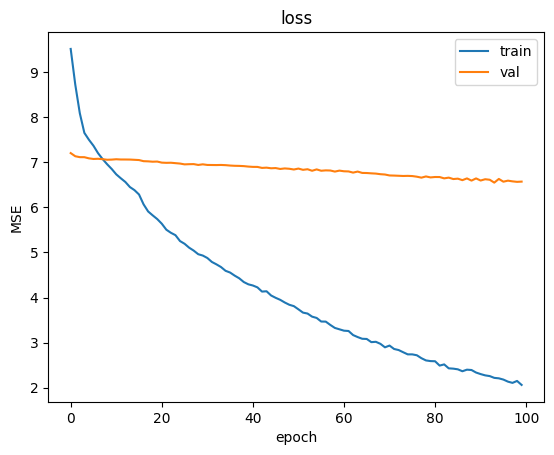

In [64]:
# Window = 3

plt.plot(kronos3s_hist.history['loss'])
plt.plot(kronos3s_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val'] , loc = "upper right")
plt.show()

In [ ]:
test_df = Data_POST[window*14:].copy()

# test set
cls = {k:[] for k in range(1,11)}
for i,plane in enumerate(kronos3s_test_results):
    for j,row in enumerate(plane):
        for k,col in enumerate(row):
            for idx in range(1,11):
                cls[idx].append(col[idx-1])
# append to the val dataset
for idx in range(1,11):
    test_df[f'pred{idx}'] = cls[idx]  
test_df['dataset'] = 'test'
test_df['model'] = para_model_name


# append all results below (col num stay the same)
all_test = test_df


# calculate mean/std/MSE
all_test['yr'] = all_test['flightDepartureDate'].dt.year
all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

# actual traffic
all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
# all predictions
all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
# all FvT errors
all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
# squared FvT errors for MSE
all_test['top_FvT_sqr'] = all_test['top_FvT']**2
all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2

all_test = all_test[ (all_test['real']==1)]

In [ ]:
# top/mid/bot/sum - FvT mean/std/MSE
print('Kronos_3s, window 3')
print([all_test['top_FvT'].mean(), all_test['top_FvT'].std(), all_test['top_FvT_sqr'].mean()])
print([all_test['mid_FvT'].mean(), all_test['mid_FvT'].std(), all_test['mid_FvT_sqr'].mean()])
print([all_test['bot_FvT'].mean(), all_test['bot_FvT'].std(), all_test['bot_FvT_sqr'].mean()])
print([all_test['sum_FvT'].mean(), all_test['sum_FvT'].std(), all_test['sum_FvT_sqr'].mean()])

In [ ]:
# Window = 1

plt.plot(kronos3s_hist.history['loss'])
plt.plot(kronos3s_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val'] , loc = "upper right")
plt.show()

In [ ]:
test_df = Data_POST[window*14:].copy()

# test set
cls = {k:[] for k in range(1,11)}
for i,plane in enumerate(kronos3s_test_results):
    for j,row in enumerate(plane):
        for k,col in enumerate(row):
            for idx in range(1,11):
                cls[idx].append(col[idx-1])
# append to the val dataset
for idx in range(1,11):
    test_df[f'pred{idx}'] = cls[idx]  
test_df['dataset'] = 'test'
test_df['model'] = para_model_name


# append all results below (col num stay the same)
all_test = test_df


# calculate mean/std/MSE
all_test['yr'] = all_test['flightDepartureDate'].dt.year
all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

# actual traffic
all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
# all predictions
all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
# all FvT errors
all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
# squared FvT errors for MSE
all_test['top_FvT_sqr'] = all_test['top_FvT']**2
all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2

all_test = all_test[ (all_test['real']==1)]


# top/mid/bot/sum - FvT mean/std/MSE
print('Kronos_3s, window 1')
print([all_test['top_FvT'].mean(), all_test['top_FvT'].std(), all_test['top_FvT_sqr'].mean()])
print([all_test['mid_FvT'].mean(), all_test['mid_FvT'].std(), all_test['mid_FvT_sqr'].mean()])
print([all_test['bot_FvT'].mean(), all_test['bot_FvT'].std(), all_test['bot_FvT_sqr'].mean()])
print([all_test['sum_FvT'].mean(), all_test['sum_FvT'].std(), all_test['sum_FvT_sqr'].mean()])

In [ ]:
# Window = 5, DOW

plt.plot(kronos3s_hist.history['loss'])
plt.plot(kronos3s_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val'] , loc = "upper right")
plt.show()

In [896]:
len(Data_POST)/14

323.0

In [891]:
# test set
cls = {k:[] for k in range(1,11)}
for i,plane in enumerate(kronos3s_test_results):
    for j,row in enumerate(plane):
        for k,col in enumerate(row):
            for idx in range(1,11):
                cls[idx].append(col[idx-1])

In [897]:
 ## GET THE DATA WHEN CHENGING TO DOW
len(Data_POST)/14 - len(cls[1])/14

35.0

In [ ]:
test_df = Data_POST[window*14:].copy()

# test set
cls = {k:[] for k in range(1,11)}
for i,plane in enumerate(kronos3s_test_results):
    for j,row in enumerate(plane):
        for k,col in enumerate(row):
            for idx in range(1,11):
                cls[idx].append(col[idx-1])
# append to the val dataset
for idx in range(1,11):
    test_df[f'pred{idx}'] = cls[idx]  
test_df['dataset'] = 'test'
test_df['model'] = para_model_name


# append all results below (col num stay the same)
all_test = test_df


# calculate mean/std/MSE
all_test['yr'] = all_test['flightDepartureDate'].dt.year
all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

# actual traffic
all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
# all predictions
all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
# all FvT errors
all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
# squared FvT errors for MSE
all_test['top_FvT_sqr'] = all_test['top_FvT']**2
all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2

all_test = all_test[ (all_test['real']==1)]


# top/mid/bot/sum - FvT mean/std/MSE
print('Kronos_3s, window 5, DOW')
print([all_test['top_FvT'].mean(), all_test['top_FvT'].std(), all_test['top_FvT_sqr'].mean()])
print([all_test['mid_FvT'].mean(), all_test['mid_FvT'].std(), all_test['mid_FvT_sqr'].mean()])
print([all_test['bot_FvT'].mean(), all_test['bot_FvT'].std(), all_test['bot_FvT_sqr'].mean()])
print([all_test['sum_FvT'].mean(), all_test['sum_FvT'].std(), all_test['sum_FvT_sqr'].mean()])

## 2nd Iter: TC Time-Serries

Now we focus more on applying the Time-series on Trrafic.

We developed two data:
1. Time-series based on Day
2. Time-series based on DOW.

### Data preprocessing:


In [499]:
# Pre: pre-covid period, used for train and validation
# Post: post-covid period, used for test

# Cut the 'post' data into Pre-covid and Post-covid parts
Data_PRE = post[ (post['flightDepartureDate']>=Pre_start) & (post['flightDepartureDate']<=Pre_end) ]
Data_POST = post[ (post['flightDepartureDate']>=Post_start) & (post['flightDepartureDate']<=Post_end) ]
Data_FUTURE = post[ (post['flightDepartureDate']>=future_start) & (post['flightDepartureDate']<=future_end) ]

print(Data_PRE.shape)
print(Data_POST.shape)
print(Data_FUTURE.shape)

(10178, 83)
(4690, 83)
(1470, 83)


In [733]:
def randPeriod(prdMaps):
    # print(x)
    random_period = np.random.randint(1,7)
    rrd_start, rrt_end = prdMaps[prdMaps['FORECASTPERIOD']==random_period].loc[:,["RRD_START", "RRD_END"]].values[0]
    random_day = np.random.randint(rrd_start, rrt_end )
    return random_period , random_day


def tf_timeseries_masking( tf_tensors , data_index , prdMaps , window  ):
    """This function will generate masked time-seried terrafic data."""
    
    random_period , random_day_to_dept = randPeriod(prdMaps)
    # print(random_period , random_day_to_dept )
    arr =  prdMaps.iloc[:,3].values
    
    # output = tf_tensors[data_index].copy()
    test_tensors = tf_tensors.copy()
    test_tensors[data_index][:,:random_period,] = -1
    
    
    max_bond_period = random_day_to_dept
    min_bond_period = arr[random_period-1]
    remaining_window = window - 1
    current_index = data_index
    max_min_range = max_bond_period - min_bond_period
    current_period = random_period

    if  max_min_range < remaining_window:
        while max_min_range  <= remaining_window:
            # print(current_index-max_min_range,current_index)
            test_tensors[current_index-max_min_range:current_index,:,:current_period,] = -1
            current_period -= 1
            if current_period == 0:
                break
            current_index -= max_min_range
            remaining_window -=  max_min_range
            max_bond_period -= max_min_range
            min_bond_period = arr[current_period-1]
            max_min_range = max_bond_period - min_bond_period
            # reaching Today date:

    if max_min_range >= remaining_window:
        # print(current_index-max_min_range,current_index)
        test_tensors[current_index-remaining_window:current_index,:,:current_period,] = -1
        
    return test_tensors[data_index+1-window:data_index+1] 


def get_tensors2(DataFarame, sea_col_Cap, prdMaps= None , FC_time_series = True , traffic_time_series = False ,  use_channels = False , seasenality_one_dimension = True ,  window = 10, DOW=False):
    
    len_sea_cap = len(sea_col_Cap)
            
    
    # fractional closure
    PRE_FC_L = DataFarame[['fracClosure_' + str(i + 1) for i in range(10)]].values.astype('float32')
    # seasonality
    PRE_Sea_L = DataFarame[sea_col_Cap].values.astype('float32')
    # actual traffic
    PRE_Traf_L = DataFarame[['trafficActual_' + str(i + 1) for i in range(10)]].values.astype('float32')
    
    
    # reshape the data for CNNLSTM model
    FC = PRE_FC_L.reshape(int(PRE_FC_L.shape[0]/14), 1, 14, 10)
    Seasenality = PRE_Sea_L.reshape(int(PRE_Sea_L.shape[0]/14), 1,14, len_sea_cap)
    Traffic = PRE_Traf_L.reshape(int(PRE_Traf_L.shape[0]/14), 1, 14, 10)
    
    # Remove Duplicates (from 2d to 1d vector)
    if seasenality_one_dimension:
        Seasenality =np.delete(Seasenality, slice(13), 2).reshape(Seasenality.shape[0],len_sea_cap)
    
    
    if use_channels:
        FC = FC.reshape(len(FC),2,7,10)
        Traffic = Traffic.reshape(len(Traffic),2,7,10)
    
    # Change FC shape to refelect time series:
    # print(FC.shape)
    if FC_time_series:
        time_series_widow= list()
        Seasenality_times = list()
        for i in range(window,len(FC)):
            # print(FC[i-window:i].shape)
            time_series_widow.append(FC[i-window:i].reshape(window,2,7,10))
            # print((Seasenality[i-window:i].shape))
            Seasenality_times.append(Seasenality[i-window:i])
        FC = np.array(time_series_widow)
        Seasenality = np.array(Seasenality_times)
        
        # Since the 1st window size data points are removed:
        # Seasenality = Seasenality[window:]
        Traffic = Traffic[window:]
    
    elif traffic_time_series:
        traffic_time_series_window = list()
        Seasenality_times = list()
        for i in range(window,len(Traffic)):
            # Find Random period and random day:
            random_period , random_day_to_dept = randPeriod(prdMaps)
            if DOW:
                tf_window_masked = tf_timeseries_masking_DOW( Traffic  , i , prdMaps , window  )
            else:
                tf_window_masked = tf_timeseries_masking( Traffic  , i , prdMaps , window  )
            traffic_time_series_window.append(tf_window_masked)
            # Seasenality_times.append(Seasenality[i-window:i])
        
        TF_time = np.array(traffic_time_series_window)
        # Seasenality = np.array(Seasenality_times)
        Seasenality = Seasenality[window:]
        FC = FC[window:]
        
        Traffic = Traffic[window:]
            
        
        return FC, Seasenality, Traffic, TF_time
    
        
    return FC, Seasenality, Traffic, _




def floorSearch(arr, low, high, x):
 
    # If low and high cross each other
    if (low > high):
        return -1
 
    # If last element is smaller than x
    if (x >= arr[high]):
        return high
 
    # Find the middle point
    mid = int((low + high) / 2)
 
    # If middle point is floor.
    if (arr[mid] == x):
        return mid
 
    # If x lies between mid-1 and mid
    if (mid > 0 and arr[mid-1] <= x
            and x < arr[mid]):
        return mid - 1
 
    # If x is smaller than mid,
    # floor must be in left half.
    if (x < arr[mid]):
        return floorSearch(arr, low, mid-1, x)
 
    # If mid-1 is not floor and x is greater than
    # arr[mid],
    return floorSearch(arr, mid + 1, high, x)


def tf_timeseries_masking_DOW( tf_tensors , data_index , prdMaps , window  ):
    """This function will generate masked time-seried terrafic data, and is based on DOW."""
    
    random_period , random_day_to_dept = randPeriod(prdMaps)
    arr =  prdMaps.iloc[:,3].values
    test_tensors = tf_tensors.copy()
    
    day_to_dept = random_day_to_dept
    current_index = data_index
    
    for i in range(0,window):
        # Move back 7 days in each iter.
        day_to_dept = random_day_to_dept - i*7 
        # Get the period of that day to dept.
        flrs = floorSearch(arr, 0, 6, day_to_dept)
        current_period = flrs+1
        # If we get today, will break the loop. and use all the values (no masking)
        if current_period == 0:
            break
        # mask the values
        test_tensors[current_index,:,:current_period,] = -1
        
        # Update index:
        current_index -= 1
        
    return test_tensors[data_index+1-window:data_index+1]    
    

        


# def dow_get_tensors2(DataFarame , sea_col_Cap, prdMaps= None  ,  test = False, time_series = True,  use_channels = False , window = 10):   
def dow_get_tensors2(DataFarame , sea_col_Cap, prdMaps= None  ,  FC_time_series = True , traffic_time_series = False ,  use_channels = False , seasenality_one_dimension = True ,  window = 10):
    DOW = True
    FC_dow , Seasenality_dow, Traffic_dow ,  TF_time_dow  = list(), list(), list(), list()
    
    for i in DataFarame.loc[ :,	['dow_x' ,	'dow_y' ]].drop_duplicates().values:
        filter_y = DataFarame['dow_y' ] == i[1] 
        filter_x = DataFarame['dow_x'] == i[0] 
        # print(filter_y.shape , filter_x.shape)
        # print(i)
        Data_dow =DataFarame[filter_x & filter_y]
        # print(Data_dow.shape)
        FC, Seasenality, Traffic, TF_time= get_tensors2(Data_dow, sea_col_Cap, prdMaps  , FC_time_series  , traffic_time_series ,  use_channels  , seasenality_one_dimension  ,  window, DOW )
        FC_dow.append(FC)
        Seasenality_dow.append(Seasenality)
        Traffic_dow.append(Traffic)
        if traffic_time_series:
            TF_time_dow.append(TF_time)
    
    # Then Concat together, now each datapoint is based on DOW.
    FC_dow = [ i  for i in FC_dow if i.shape!=(0,)]
    Seasenality_dow = [ i  for i in Seasenality_dow if i.shape!=(0,)]
    # Traffic_dow = [ i  for i in Traffic_dow if i.shape!=(0,)]
    
    if traffic_time_series:
        TF_time_dow = [ i  for i in TF_time_dow if i.shape!=(0,)]
        TF_time_dow = np.concatenate(TF_time_dow)
    
    FC_dow = np.concatenate(FC_dow)
    Seasenality_dow = np.concatenate(Seasenality_dow)
    Traffic_dow = np.concatenate(Traffic_dow)
    
    return FC_dow , Seasenality_dow, Traffic_dow , TF_time_dow

In [734]:
#Get period map information
# prdMaps = pd.read_sql(f"""select DISTINCT leg_orig as origin, leg_dest as destination, fcst_period as forecastPeriod, rrd_band_start_i as rrd_start, rrd_band_end_i as rrd_end
#                             from market_xref a 
#                             join FCST.FCST_PERIOD_REF b 
#                             on a.infl_period_id = b.FCST_PERIOD_ID
#                             where 1=1 
#                             and cabin_code = 'Y'
#                             and leg_orig = '{orig}'
#                             and leg_dest = '{dest}'
#                             ORDER BY forecastPeriod
#                             """, con = hcrt)

In [735]:
# Trrafic Timeseries.
##TODO: for the future flights, we should just use today days as refrance.
sea_col_Cap = ['week_x', 'week_y','dow_x', 'dow_y', 'avgrasm','seats_AA_fcst','seats_OA_fcst','seats_ulcc_fcst' , 'seats_AA' , 'seats_OA' , 'seats_ulcc']
sea_col = ['week_x', 'week_y', 'dow_x', 'dow_y','avgrasm','dowavgrasm']


PRE_FC_32S , PRE_Seas_32S , PRE_Traf_32S , PRE_TF_timeseries_32S = get_tensors2(Data_PRE, sea_col_Cap, prdMaps  , FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,   window = window)
POST_FC_32S , POST_Seas_32S , POST_Traf_32S , POST_TF_timeseries_32S = get_tensors2(Data_POST, sea_col_Cap, prdMaps , FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,   window = window)
# FUTURE_FC_32S , FUTURE_Seas_32S , FUTURE_Traf_32S , FUTURE_TF_timeseries_32S = get_tensors2(Data_FUTURE, sea_col_Cap, prdMaps , FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,   window = window)

## *********** NEEDS TO BE CHECKED *********** : I think the given DOW is wrong for the fake data point CHECK

PRE_FC_DOW_32S , PRE_Seas_DOW_32S , PRE_Traf_DOW_32S, PRE_TF_timeseries_DOW_32S  =           dow_get_tensors2(Data_PRE , sea_col_Cap, prdMaps  , FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,   window = window)
POST_FC_DOW_32S , POST_Seas_DOW_32S , POST_Traf_DOW_32S , POST_TF_timeseries_DOW_32S =     dow_get_tensors2(Data_POST , sea_col_Cap, prdMaps  , FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,   window = window)
# FUTURE_FC_DOW_32S , FUTURE_Seas_DOW_32S , FUTURE_Traf_DOW_32S ,FUTUR_TF_timeseries_DOW_32S = dow_get_tensors2(Data_FUTURE , sea_col_Cap, prdMaps  , FC_time_series = False , traffic_time_series = True ,  use_channels = True , seasenality_one_dimension = True ,   window = window)


print("Daily:")
print(PRE_FC_32S.shape , PRE_Seas_32S.shape , PRE_Traf_32S.shape , PRE_TF_timeseries_32S.shape)
print(POST_FC_32S.shape , POST_Seas_32S.shape, POST_Traf_32S.shape , POST_TF_timeseries_32S.shape)
# print(FUTURE_FC_32S.shape , FUTURE_Seas_32S.shape , FUTURE_Traf_32S.shape ,  FUTURE_TF_timeseries_32S.shape )

print("DOW:")
print(PRE_FC_DOW_32S.shape , PRE_Seas_DOW_32S.shape , PRE_Traf_DOW_32S.shape, PRE_TF_timeseries_DOW_32S.shape)
print(POST_FC_DOW_32S.shape , POST_Seas_DOW_32S.shape, POST_Traf_DOW_32S.shape , POST_TF_timeseries_DOW_32S.shape )
# print(FUTURE_FC_DOW_32S.shape , FUTURE_Seas_DOW_32S.shape, FUTURE_Traf_DOW_32S.shape , FUTUR_TF_timeseries_DOW_32S.shape )


Daily:
(717, 2, 7, 10) (717, 11) (717, 2, 7, 10) (717, 10, 2, 7, 10)
(325, 2, 7, 10) (325, 11) (325, 2, 7, 10) (325, 10, 2, 7, 10)
DOW:
(657, 2, 7, 10) (657, 11) (657, 2, 7, 10) (657, 10, 2, 7, 10)
(265, 2, 7, 10) (265, 11) (265, 2, 7, 10) (265, 10, 2, 7, 10)


In [736]:
# Kronos input with new features (With Cap data)

# 80, 20 --> 
# TODO: THIS SHOULD BE CHANGED TO RANDOMIZED.
train_test_cutoff = round(PRE_FC_32S.shape[0]*0.9) 


# prepare train/val/test datasets
PRE_FC_32S_train = PRE_FC_32S[:train_test_cutoff, :]
PRE_FC_32S_val = PRE_FC_32S[train_test_cutoff:, :]

PRE_Seas_32S_train = PRE_Seas_32S[:train_test_cutoff, :]
PRE_Seas_32S_val = PRE_Seas_32S[train_test_cutoff:, :]

PRE_Traf_32S_train = PRE_Traf_32S[:train_test_cutoff, :]
PRE_Traf_32S_val = PRE_Traf_32S[train_test_cutoff:, :]

PRE_TF_timeseries_32S_train = PRE_TF_timeseries_32S[:train_test_cutoff, :]
PRE_TF_timeseries_32S_val = PRE_TF_timeseries_32S[train_test_cutoff:, :]



train_32s = [PRE_FC_32S_train,PRE_Seas_32S_train,PRE_TF_timeseries_32S_train,PRE_Traf_32S_train]
val_32s = [PRE_FC_32S_val,PRE_Seas_32S_val,PRE_TF_timeseries_32S_val,PRE_Traf_32S_val]
test_32s = [POST_FC_32S,POST_Seas_32S,POST_TF_timeseries_32S]


In [737]:
# Kronos input with new features (With Cap data)

# 80, 20 --> 
# TODO: THIS SHOULD BE CHANGED TO RANDOMIZED.
train_test_cutoff = round(PRE_FC_DOW_32S.shape[0]*0.9) 


# prepare train/val/test datasets
PRE_FC_32S_DOW_train = PRE_FC_DOW_32S[:train_test_cutoff, :]
PRE_FC_32S_DOW_val = PRE_FC_DOW_32S[train_test_cutoff:, :]

PRE_Seas_32S_DOW_train = PRE_Seas_DOW_32S[:train_test_cutoff, :]
PRE_Seas_32S_DOW_val = PRE_Seas_DOW_32S[train_test_cutoff:, :]

PRE_Traf_32S_DOW_train = PRE_Traf_DOW_32S[:train_test_cutoff, :]
PRE_Traf_32S_DOW_val = PRE_Traf_DOW_32S[train_test_cutoff:, :]

PRE_TF_timeseries_32S_DOW_train = PRE_TF_timeseries_DOW_32S[:train_test_cutoff, :]
PRE_TF_timeseries_32S_DOW_val = PRE_TF_timeseries_DOW_32S[train_test_cutoff:, :]



train_32s_DOW = [PRE_FC_32S_DOW_train,PRE_Seas_32S_DOW_train,PRE_TF_timeseries_32S_DOW_train,PRE_Traf_32S_DOW_train]
val_32s_DOW = [PRE_FC_32S_DOW_val,PRE_Seas_32S_DOW_val,PRE_TF_timeseries_32S_DOW_val,PRE_Traf_32S_DOW_val]
test_32s_DOW = [POST_FC_DOW_32S , POST_Seas_DOW_32S , POST_TF_timeseries_DOW_32S]


### Kronos 3.2 Model:

In [758]:
import os
from keras import backend as K 
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import ConvLSTM2D, Reshape , TimeDistributed, BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten, Conv2D, Bidirectional, GRU, Conv3D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import random


# baseline model (current Kronos 2.0)

para_epochs = 300
para_early_stop = True
para_model_name = 'base'
para_sea_len = 11
para_sea_dense = 128


batch_size = 100
early_stop = 100
filter_num = 16
rec_act = 'relu'
rec_dropout = 0.1
dropout = 0.1
lstm_size = 64
patience= early_stop
batch_size_nbr = batch_size
Error_Method = 'MC_dropout'
B = batch_size


# Input sizes: 
K.clear_session()
input_tensor_closure = Input(shape = (2,7,10,1)) # lets use 3D with Channel of 1
input_tensor_seas = Input(shape = (para_sea_len))
input_tensor_trrafic_tseries = Input(shape = (window ,2,7,10))

# Feed the TF-t-series to ConvLSTM:
cnn_lstm_tf_time = ConvLSTM2D(filters = filter_num , kernel_size = 3, padding = 'same', data_format = 'channels_first', 
                              recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = True)(input_tensor_trrafic_tseries)
cnn_lstm_tf_time = BatchNormalization(axis = 1)(cnn_lstm_tf_time)
cnn_lstm_tf_time = ConvLSTM2D(filters = filter_num//4 , kernel_size = 2, padding = 'same', data_format = 'channels_first', 
                              recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = False)(cnn_lstm_tf_time)
cnn_lstm_tf_time = BatchNormalization(axis = 1)(cnn_lstm_tf_time)
print(cnn_lstm_tf_time)
cnn_lstm_tf_time = Flatten()(cnn_lstm_tf_time)
cnn_lstm_tf_time = Dense(128, activation=rec_act)(cnn_lstm_tf_time)

# print(cnn_lstm_tf_time)


# # layer for seasonality Using a RNN (Here GRU instead of LSTM)
# rnn_seas = GRU(lstm_size, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = False  )(input_tensor_seas)
# # rnn_seas = Bidirectional(GRU(lstm_size//2, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = False ))(rnn_seas)
# rnn_seas = BatchNormalization()(rnn_seas)
# rnn_seas = Dense(64, activation=rec_act)(rnn_seas)

# Seas No RNN:
rnn_seas = Dense(128, activation=rec_act)(input_tensor_seas)
rnn_seas = Dense(64, activation=rec_act)(rnn_seas)


# print(rnn_seas)


# layer for FC:
cnn_FC = Conv3D(filters = filter_num//4 , kernel_size = 3, strides = (1, 1, 1), padding = 'same', data_format = 'channels_last')(input_tensor_closure)
cnn_FC = BatchNormalization()(cnn_FC)
cnn_FC = Flatten()(cnn_FC)
cnn_FC = Dense(64, activation=rec_act)(cnn_FC)

# print(cnn_FC)


# concat frac_closure and seasonality and TF_sries
FF_concat_all = Concatenate()([cnn_lstm_tf_time, rnn_seas, cnn_FC])
# FF_concat_all = Dense(256, activation=rec_act)(FF_concat_all)
FF_concat_all = Dense(140, activation=rec_act)(FF_concat_all)

# # Output format:
output_tensor = Reshape((2, 7, 10))(FF_concat_all)

# print(output_tensor)


# Kronos model setting
Kronos_model = Model(inputs = [ input_tensor_closure, input_tensor_seas, input_tensor_trrafic_tseries], outputs = output_tensor)
Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 7, 10), dtype=tf.float32, name=None), name='batch_normalization_1/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1'")


In [739]:
Kronos_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10, 2, 7, 1  0           []                               
                                0)]                                                               
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 10, 16, 7, 1  10432       ['input_3[0][0]']                
                                0)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 16, 7, 1  40         ['conv_lstm2d[0][0]']            
 alization)                     0)                                                            

In [740]:
# Kronos Model
import os
from keras import backend as K 
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Reshape , BatchNormalization, LSTM, Concatenate, Dense, Activation, Flatten, Conv2D, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import random


def kronos_32s_model(para_epochs, para_early_stop, para_model_name, para_sea_len, para_sea_dense, window, train_list, val_list, test_list):
        
    # Set Random Seed 
    seed_value = 44
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    
    # extract train/val/test datasets  ** since TF.keras only accepts channels_last we have to move axix **
    train_fc, train_sea, train_traf_time, train_output = train_list
    val_fc, val_sea, val_traf_time, val_output = val_list
    test_fc, test_sea, test_traf_time = test_list
    
    # Reshape for Conv3d with channel 1.
    train_fc, val_fc, test_fc = train_fc.reshape(list(train_fc.shape)+[1]), val_fc.reshape(list(val_fc.shape)+[1]), test_fc.reshape(list(test_fc.shape)+[1]) 
    
    
    # Model Parameters:
    batch_size = 100
    early_stop = 100
    filter_num = 16
    rec_act = 'relu'
    rec_dropout = 0.1
    dropout = 0.1
    lstm_size = 64
    patience= early_stop
    batch_size_nbr = batch_size
    Error_Method = 'MC_dropout'
    B = batch_size


    # Input sizes: 
    K.clear_session()
    input_tensor_closure = Input(shape = (2,7,10,1)) # lets use 3D with Channel of 1
    input_tensor_seas = Input(shape = (window ,para_sea_len))
    input_tensor_seas = Input(shape = (para_sea_len))
    input_tensor_trrafic_tseries = Input(shape = (window ,2,7,10))

    # Feed the TF-t-series to ConvLSTM:
    cnn_lstm_tf_time = ConvLSTM2D(filters = filter_num , kernel_size = 3, padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = True)(input_tensor_trrafic_tseries)
    cnn_lstm_tf_time = BatchNormalization(axis = 1)(cnn_lstm_tf_time)
    cnn_lstm_tf_time = ConvLSTM2D(filters = filter_num//4 , kernel_size = 2, padding = 'same', data_format = 'channels_first', 
                                  recurrent_activation = rec_act, recurrent_dropout = rec_dropout, dropout=dropout ,  return_sequences = False)(cnn_lstm_tf_time)
    cnn_lstm_tf_time = BatchNormalization(axis = 1)(cnn_lstm_tf_time)
    cnn_lstm_tf_time = Flatten()(cnn_lstm_tf_time)
    cnn_lstm_tf_time = Dense(128, activation=rec_act)(cnn_lstm_tf_time)

    # print(cnn_lstm_tf_time)


    # # layer for seasonality Using a RNN (Here GRU instead of LSTM)
    # rnn_seas = GRU(lstm_size, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = False  )(input_tensor_seas)
    # # rnn_seas = Bidirectional(GRU(lstm_size//2, recurrent_dropout = rec_dropout, dropout=dropout  , return_sequences = False ))(rnn_seas)
    # rnn_seas = BatchNormalization()(rnn_seas)
    # rnn_seas = Dense(64, activation=rec_act)(rnn_seas)

    # Seas No RNN:
    rnn_seas = Dense(128, activation=rec_act)(input_tensor_seas)
    rnn_seas = Dense(64, activation=rec_act)(rnn_seas)


    # print(rnn_seas)


    # layer for FC:
    cnn_FC = Conv3D(filters = filter_num//4 , kernel_size = 3, strides = (1, 1, 1), padding = 'same', data_format = 'channels_last')(input_tensor_closure)
    cnn_FC = BatchNormalization()(cnn_FC)
    cnn_FC = Flatten()(cnn_FC)
    cnn_FC = Dense(64, activation=rec_act)(cnn_FC)

    # print(cnn_FC)


    # concat frac_closure and seasonality and TF_sries
    FF_concat_all = Concatenate()([cnn_lstm_tf_time, rnn_seas, cnn_FC])
    # FF_concat_all = Dense(256, activation=rec_act)(FF_concat_all)
    FF_concat_all = Dense(140, activation=rec_act)(FF_concat_all)

    # # Output format:
    output_tensor = Reshape((2, 7, 10))(FF_concat_all)

    # print(output_tensor)


    # Kronos model setting
    Kronos_model = Model(inputs = [ input_tensor_closure, input_tensor_seas, input_tensor_trrafic_tseries], outputs = output_tensor)
    Kronos_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    if para_early_stop: # with early stop
        
        os.chdir(r"\\corpaa.aa.com\campusshared\HDQ\HDQ_REVMGMT_Share\RMDEPT")
        path = "BFox/Kronos/Prototype/Output/FullPeriod/"
        market_nm = orig + dest
        # if not os.path.exists(path):
            # os.mkdir(path)
        
        # history = History()
        metric = 'val_accuracy'
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience , restore_best_weights=True)
        mc = ModelCheckpoint(path + '//' + market_nm + '_' + 'best_model.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True, save_freq='epoch')
        base_hist = Kronos_model.fit([train_fc, train_sea, train_traf_time], train_output, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([ val_fc, val_sea, val_traf_time], val_output), verbose = 2, callbacks=[es,mc])
    else: # no early stop
        base_hist = Kronos_model.fit([train_fc, train_sea, train_traf_time], train_output, epochs = para_epochs, 
                                 batch_size = batch_size_nbr, validation_data = ([ val_fc, val_sea, val_traf_time], val_output) , verbose = 0)
         
    
    # use the trained model to predict
    test_pred = Kronos_model.predict([ test_fc, test_sea, test_traf_time])

    return test_pred, base_hist, Kronos_model

#     # copy of train/test/val dataset to store prediction results
#     test_df = Data_POST.copy()
    
     
#     # test set
#     cls = {k:[] for k in range(1,11)}
#     for i,plane in enumerate(test_pred):
#         for j,row in enumerate(plane):
#             for k,col in enumerate(row):
#                 for idx in range(1,11):
#                     cls[idx].append(col[idx-1])
#     # append to the val dataset
#     for idx in range(1,11):
#         test_df[f'pred{idx}'] = cls[idx]  
#     test_df['dataset'] = 'test'
#     test_df['model'] = para_model_name
    
    
#     # append all results below (col num stay the same)
#     all_test = test_df
    
    
#     # calculate mean/std/MSE
#     all_test['yr'] = all_test['flightDepartureDate'].dt.year
#     all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

#     # actual traffic
#     all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
#     all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
#     all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
#     all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
#     # all predictions
#     all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
#     all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
#     all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
#     all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
#     # all FvT errors
#     all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
#     all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
#     all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
#     all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
#     # squared FvT errors for MSE
#     all_test['top_FvT_sqr'] = all_test['top_FvT']**2
#     all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
#     all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
#     all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2
    
#     all_test = all_test[ (all_test['real']==1)]
    

#     return all_test, base_hist, Kronos_model


In [652]:
kronos32s_test_results , kronos32s_hist,  kronos32s_model = kronos_32s_model(para_epochs = 100, para_early_stop =  True, para_model_name = 'kronos32s', para_sea_len = len(sea_col_Cap), para_sea_dense =  160, window = window ,
             train_list = train_32s , val_list = val_32s, test_list = test_32s)

Epoch 1/100
7/7 - 16s - loss: 8.4500 - val_loss: 6.9951 - 16s/epoch - 2s/step
Epoch 2/100
7/7 - 16s - loss: 6.8491 - val_loss: 6.9381 - 16s/epoch - 2s/step
Epoch 3/100
7/7 - 8s - loss: 6.1551 - val_loss: 6.8698 - 8s/epoch - 1s/step
Epoch 4/100
7/7 - 8s - loss: 5.6463 - val_loss: 6.8253 - 8s/epoch - 1s/step
Epoch 5/100
7/7 - 8s - loss: 5.1822 - val_loss: 6.7777 - 8s/epoch - 1s/step
Epoch 6/100
7/7 - 8s - loss: 4.8273 - val_loss: 6.7222 - 8s/epoch - 1s/step
Epoch 7/100
7/7 - 16s - loss: 4.5162 - val_loss: 6.6857 - 16s/epoch - 2s/step
Epoch 8/100
7/7 - 9s - loss: 4.2223 - val_loss: 6.6158 - 9s/epoch - 1s/step
Epoch 9/100
7/7 - 10s - loss: 3.9365 - val_loss: 6.5616 - 10s/epoch - 1s/step
Epoch 10/100
7/7 - 8s - loss: 3.7652 - val_loss: 6.5136 - 8s/epoch - 1s/step
Epoch 11/100
7/7 - 8s - loss: 3.5190 - val_loss: 6.4473 - 8s/epoch - 1s/step
Epoch 12/100
7/7 - 18s - loss: 3.3583 - val_loss: 6.3945 - 18s/epoch - 3s/step
Epoch 13/100
7/7 - 10s - loss: 3.2405 - val_loss: 6.3500 - 10s/epoch - 1s/s

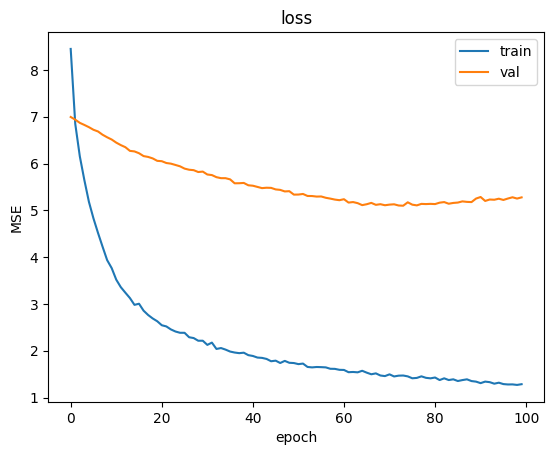

In [653]:
plt.plot(kronos32s_hist.history['loss'])
plt.plot(kronos32s_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val'] , loc = "upper right")
plt.show()

In [654]:
test_df = Data_POST[window*14:].copy()

# test set
cls = {k:[] for k in range(1,11)}
for i,plane in enumerate(kronos32s_test_results):
    for j,row in enumerate(plane):
        for k,col in enumerate(row):
            for idx in range(1,11):
                cls[idx].append(col[idx-1])
# append to the val dataset
for idx in range(1,11):
    test_df[f'pred{idx}'] = cls[idx]  
test_df['dataset'] = 'test'
test_df['model'] = para_model_name


# append all results below (col num stay the same)
all_test = test_df


# calculate mean/std/MSE
all_test['yr'] = all_test['flightDepartureDate'].dt.year
all_test['weekNumber'] = pd.to_datetime(all_test['flightDepartureDate']).dt.isocalendar().week

# actual traffic
all_test['top_trf'] = all_test['trafficActual_1'] + all_test['trafficActual_2'] + all_test['trafficActual_3'] 
all_test['mid_trf'] = all_test['trafficActual_4'] + all_test['trafficActual_5'] + all_test['trafficActual_6'] + all_test['trafficActual_7'] 
all_test['bot_trf'] = all_test['trafficActual_8'] + all_test['trafficActual_9'] + all_test['trafficActual_10'] 
all_test['sum_trf'] = all_test['top_trf']+all_test['mid_trf']+all_test['bot_trf']
# all predictions
all_test['top_pred'] = all_test['pred1'] + all_test['pred2'] + all_test['pred3'] 
all_test['mid_pred'] = all_test['pred4'] + all_test['pred5'] + all_test['pred6'] + all_test['pred7'] 
all_test['bot_pred'] = all_test['pred8'] + all_test['pred9'] + all_test['pred10'] 
all_test['sum_pred'] = all_test['top_pred']+all_test['mid_pred']+all_test['bot_pred']
# all FvT errors
all_test['top_FvT'] = all_test['top_pred'] - all_test['top_trf']
all_test['mid_FvT'] = all_test['mid_pred'] - all_test['mid_trf']
all_test['bot_FvT'] = all_test['bot_pred'] - all_test['bot_trf']
all_test['sum_FvT'] = all_test['sum_pred'] - all_test['sum_trf']
# squared FvT errors for MSE
all_test['top_FvT_sqr'] = all_test['top_FvT']**2
all_test['mid_FvT_sqr'] = all_test['mid_FvT']**2
all_test['bot_FvT_sqr'] = all_test['bot_FvT']**2
all_test['sum_FvT_sqr'] = all_test['sum_FvT']**2

all_test = all_test[ (all_test['real']==1)]

In [655]:
# top/mid/bot/sum - FvT mean/std/MSE
print('Kronos_32s, window 10')
print([all_test['top_FvT'].mean(), all_test['top_FvT'].std(), all_test['top_FvT_sqr'].mean()])
print([all_test['mid_FvT'].mean(), all_test['mid_FvT'].std(), all_test['mid_FvT_sqr'].mean()])
print([all_test['bot_FvT'].mean(), all_test['bot_FvT'].std(), all_test['bot_FvT_sqr'].mean()])
print([all_test['sum_FvT'].mean(), all_test['sum_FvT'].std(), all_test['sum_FvT_sqr'].mean()])

Kronos_32s, window 10
[-1.252482368276342, 4.379935978583017, 20.748335030938648]
[-1.2541971791648194, 5.460408599998786, 31.382519662488995]
[-1.4282415198618648, 5.128477644689817, 28.335376289392837]
[-3.9349210635656595, 8.185609108625803, 82.47307405868203]


In [662]:
kronos32s_test_results , kronos32s_hist,  kronos32s_model = kronos_32s_model(para_epochs = 300, para_early_stop =  True, para_model_name = 'kronos32s', para_sea_len = len(sea_col_Cap), para_sea_dense =  160, window = window ,
             train_list = train_32s_DOW , val_list = val_32s_DOW, test_list = test_32s_DOW)

Epoch 1/300
6/6 - 18s - loss: 8.4506 - val_loss: 6.8837 - 18s/epoch - 3s/step
Epoch 2/300
6/6 - 17s - loss: 7.0805 - val_loss: 6.7544 - 17s/epoch - 3s/step
Epoch 3/300
6/6 - 13s - loss: 6.3318 - val_loss: 6.6806 - 13s/epoch - 2s/step
Epoch 4/300
6/6 - 15s - loss: 5.8161 - val_loss: 6.5910 - 15s/epoch - 3s/step
Epoch 5/300
6/6 - 16s - loss: 5.4294 - val_loss: 6.5417 - 16s/epoch - 3s/step
Epoch 6/300
6/6 - 18s - loss: 5.0628 - val_loss: 6.4651 - 18s/epoch - 3s/step
Epoch 7/300
6/6 - 24s - loss: 4.7981 - val_loss: 6.4413 - 24s/epoch - 4s/step
Epoch 8/300
6/6 - 21s - loss: 4.5112 - val_loss: 6.3730 - 21s/epoch - 3s/step
Epoch 9/300
6/6 - 41s - loss: 4.2948 - val_loss: 6.3053 - 41s/epoch - 7s/step
Epoch 10/300
6/6 - 21s - loss: 4.1363 - val_loss: 6.2395 - 21s/epoch - 3s/step
Epoch 11/300
6/6 - 21s - loss: 3.9576 - val_loss: 6.1648 - 21s/epoch - 3s/step
Epoch 12/300
6/6 - 15s - loss: 3.7933 - val_loss: 6.1262 - 15s/epoch - 3s/step
Epoch 13/300
6/6 - 8s - loss: 3.6432 - val_loss: 6.0644 - 8s/

In [750]:
orig

'SEA'

In [665]:
POST_Traf_DOW_32S.shape

(265, 2, 7, 10)

In [664]:
kronos32s_test_results.shape

(265, 2, 7, 10)

In [668]:
POST_Traf_DOW_32S[1]

array([[[ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  6.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  6.,  3.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.]],

       [[ 0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 10.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]],
      dtype=float32)

In [ ]:
test_32s_DOW

In [701]:
test_size=len(POST_Traf_DOW_32S)

kronos32s_test_results.reshape(test_size*14,10)[:,3:7].sum(1).shape

(3710,)

In [705]:
results = pd.DataFrame()

test_size=len(POST_Traf_DOW_32S)

gold_tr_reshaped = POST_Traf_DOW_32S.reshape(test_size*14,10)
pred_tr_reshaped = kronos32s_test_results.reshape(test_size*14,10)

# Gold, top, mid, bot
results['gold_top_tr'] = gold_tr_reshaped[:,:3].sum(1)
results['gold_mid_tr'] = gold_tr_reshaped[:,3:7].sum(1)
results['gold_bot_tr'] = gold_tr_reshaped[:,7:].sum(1)
results['gold_sum_tr'] = gold_tr_reshaped.sum(1)

# Pred Top, Mid, Bot
results['pred_top_tr'] = pred_tr_reshaped[:,:3].sum(1)
results['pred_mid_tr'] = pred_tr_reshaped[:,3:7].sum(1)
results['pred_bot_tr'] = pred_tr_reshaped[:,7:].sum(1)
results['pred_sum_tr'] = pred_tr_reshaped.sum(1)

# all FvT errors
results['top_FvT'] = results['pred_top_tr'] - results['gold_top_tr']
results['mid_FvT'] = results['pred_mid_tr'] - results['gold_mid_tr']
results['bot_FvT'] = results['pred_bot_tr'] - results['gold_bot_tr']
results['sum_FvT'] = results['pred_sum_tr'] - results['gold_sum_tr']

# squared FvT errors for MSE
results['top_FvT_sqr'] = results['top_FvT']**2
results['mid_FvT_sqr'] = results['mid_FvT']**2
results['bot_FvT_sqr'] = results['bot_FvT']**2
results['sum_FvT_sqr'] = results['sum_FvT']**2

results 
# pd.DataFrame(POST_Traf_DOW_32S[1].reshape(14,10)[:,7:]).sum(1)

,gold_top_tr,gold_mid_tr,gold_bot_tr,gold_sum_tr,pred_top_tr,pred_mid_tr,pred_bot_tr,pred_sum_tr,top_FvT,mid_FvT,bot_FvT,sum_FvT,top_FvT_sqr,mid_FvT_sqr,bot_FvT_sqr,sum_FvT_sqr
0,0.0,4.0,2.0,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,-2.000000,-6.000000,0.000000,16.000000,4.000000,36.000000
1,0.0,1.0,0.0,1.0,0.000000,2.184272,0.623498,2.807770,0.000000,1.184272,0.623498,1.807770,0.000000,1.402500,0.388749,3.268031
2,0.0,0.0,5.0,5.0,0.000000,1.248074,0.000000,1.248074,0.000000,1.248074,-5.000000,-3.751925,0.000000,1.557690,25.000000,14.076944
3,0.0,0.0,4.0,4.0,0.000000,0.000000,2.667692,2.667692,0.000000,0.000000,-1.332308,-1.332308,0.000000,0.000000,1.775045,1.775045
4,0.0,0.0,1.0,1.0,0.000000,0.000000,0.721980,0.721980,0.000000,0.000000,-0.278020,-0.278020,0.000000,0.000000,0.077295,0.077295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705,5.0,6.0,0.0,11.0,0.527876,0.000000,0.000000,0.527876,-4.472124,-6.000000,0.000000,-10.472124,19.999889,36.000000,0.000000,109.665382
3706,3.0,2.0,0.0,5.0,0.000000,0.000000,0.000000,0.000000,-3.000000,-2.000000,0.000000,-5.000000,9.000000,4.000000,0.000000,25.000000
3707,3.0,22.0,0.0,25.0,2.493244,0.000000,3.664232,6.157475,-0.506756,-22.000000,3.664232,-18.842525,0.256802,484.000000,13.426593,355.040771
3708,27.0,34.0,0.0,61.0,7.927723,10.040772,0.000000,17.968496,-19.072277,-23.959229,0.000000,-43.031502,363.751740,574.044617,0.000000,1851.710205


In [706]:
# top/mid/bot/sum - FvT mean/std/MSE
print('Kronos_32s, window 10')
print([results['top_FvT'].mean(), results['top_FvT'].std(), results['top_FvT_sqr'].mean()])
print([results['mid_FvT'].mean(), results['mid_FvT'].std(), results['mid_FvT_sqr'].mean()])
print([results['bot_FvT'].mean(), results['bot_FvT'].std(), results['bot_FvT_sqr'].mean()])
print([results['sum_FvT'].mean(), results['sum_FvT'].std(), results['sum_FvT_sqr'].mean()])

Kronos_32s, window 10
[-1.5738776, 4.725507, 24.801487]
[-1.5257934, 6.075368, 39.228188]
[-0.917986, 4.86873, 24.540838]
[-4.0176573, 8.692942, 91.688446]


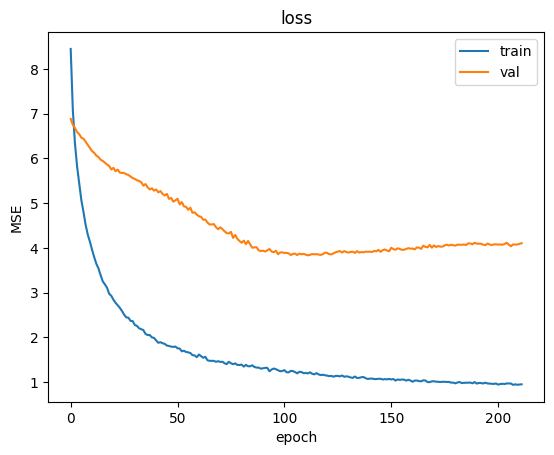

In [663]:
plt.plot(kronos32s_hist.history['loss'])
plt.plot(kronos32s_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val'] , loc = "upper right")
plt.show()

In [742]:
kronos32s_test_results , kronos32s_hist,  kronos32s_model = kronos_32s_model(para_epochs = 300, para_early_stop =  True, para_model_name = 'kronos32s', para_sea_len = len(sea_col_Cap), para_sea_dense =  160, window = window ,
             train_list = train_32s_DOW , val_list = val_32s_DOW, test_list = test_32s_DOW)

Epoch 1/300
6/6 - 30s - loss: 9.0007 - val_loss: 6.9307 - 30s/epoch - 5s/step
Epoch 2/300
6/6 - 9s - loss: 7.9987 - val_loss: 6.6674 - 9s/epoch - 1s/step
Epoch 3/300
6/6 - 10s - loss: 7.2873 - val_loss: 6.4622 - 10s/epoch - 2s/step
Epoch 4/300
6/6 - 9s - loss: 6.9216 - val_loss: 6.3903 - 9s/epoch - 2s/step
Epoch 5/300
6/6 - 8s - loss: 6.6322 - val_loss: 6.3622 - 8s/epoch - 1s/step
Epoch 6/300
6/6 - 9s - loss: 6.3978 - val_loss: 6.2986 - 9s/epoch - 1s/step
Epoch 7/300
6/6 - 10s - loss: 6.2223 - val_loss: 6.2294 - 10s/epoch - 2s/step
Epoch 8/300
6/6 - 8s - loss: 6.0456 - val_loss: 6.1621 - 8s/epoch - 1s/step
Epoch 9/300
6/6 - 8s - loss: 5.8735 - val_loss: 6.0958 - 8s/epoch - 1s/step
Epoch 10/300
6/6 - 9s - loss: 5.7586 - val_loss: 6.0380 - 9s/epoch - 2s/step
Epoch 11/300
6/6 - 8s - loss: 5.6098 - val_loss: 5.9578 - 8s/epoch - 1s/step
Epoch 12/300
6/6 - 9s - loss: 5.4641 - val_loss: 5.8930 - 9s/epoch - 2s/step
Epoch 13/300
6/6 - 8s - loss: 5.3233 - val_loss: 5.8561 - 8s/epoch - 1s/step
Ep

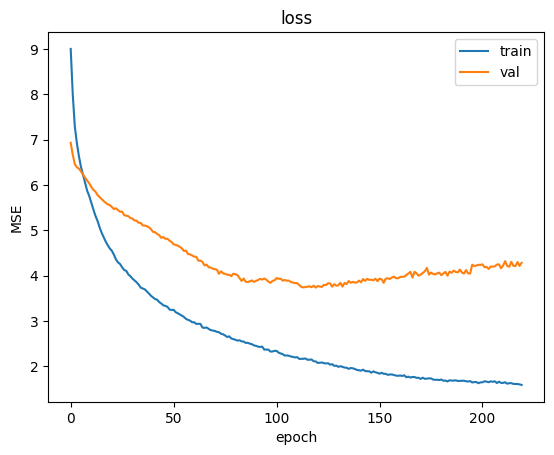

In [743]:
plt.plot(kronos32s_hist.history['loss'])
plt.plot(kronos32s_hist.history['val_loss'])
plt.title('loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','val'] , loc = "upper right")
plt.show()

In [744]:
results = pd.DataFrame()

test_size=len(POST_Traf_DOW_32S)

gold_tr_reshaped = POST_Traf_DOW_32S.reshape(test_size*14,10)
pred_tr_reshaped = kronos32s_test_results.reshape(test_size*14,10)

# Gold, top, mid, bot
results['gold_top_tr'] = gold_tr_reshaped[:,:3].sum(1)
results['gold_mid_tr'] = gold_tr_reshaped[:,3:7].sum(1)
results['gold_bot_tr'] = gold_tr_reshaped[:,7:].sum(1)
results['gold_sum_tr'] = gold_tr_reshaped.sum(1)

# Pred Top, Mid, Bot
results['pred_top_tr'] = pred_tr_reshaped[:,:3].sum(1)
results['pred_mid_tr'] = pred_tr_reshaped[:,3:7].sum(1)
results['pred_bot_tr'] = pred_tr_reshaped[:,7:].sum(1)
results['pred_sum_tr'] = pred_tr_reshaped.sum(1)

# all FvT errors
results['top_FvT'] = results['pred_top_tr'] - results['gold_top_tr']
results['mid_FvT'] = results['pred_mid_tr'] - results['gold_mid_tr']
results['bot_FvT'] = results['pred_bot_tr'] - results['gold_bot_tr']
results['sum_FvT'] = results['pred_sum_tr'] - results['gold_sum_tr']

# squared FvT errors for MSE
results['top_FvT_sqr'] = results['top_FvT']**2
results['mid_FvT_sqr'] = results['mid_FvT']**2
results['bot_FvT_sqr'] = results['bot_FvT']**2
results['sum_FvT_sqr'] = results['sum_FvT']**2

results 
# pd.DataFrame(POST_Traf_DOW_32S[1].reshape(14,10)[:,7:]).sum(1)

# top/mid/bot/sum - FvT mean/std/MSE
print('Kronos_32s, window 10')
print([results['top_FvT'].mean(), results['top_FvT'].std(), results['top_FvT_sqr'].mean()])
print([results['mid_FvT'].mean(), results['mid_FvT'].std(), results['mid_FvT_sqr'].mean()])
print([results['bot_FvT'].mean(), results['bot_FvT'].std(), results['bot_FvT_sqr'].mean()])
print([results['sum_FvT'].mean(), results['sum_FvT'].std(), results['sum_FvT_sqr'].mean()])

Kronos_32s, window 10
[-1.291054, 4.6458483, 23.244911]
[-1.126379, 7.10523, 51.73941]
[-0.043772854, 6.0533066, 36.63456]
[-2.461206, 10.197362, 110.0157]


In [746]:
results[0:14]

,gold_top_tr,gold_mid_tr,gold_bot_tr,gold_sum_tr,pred_top_tr,pred_mid_tr,pred_bot_tr,pred_sum_tr,top_FvT,mid_FvT,bot_FvT,sum_FvT,top_FvT_sqr,mid_FvT_sqr,bot_FvT_sqr,sum_FvT_sqr
0,0.0,4.0,2.0,6.0,1.675168,0.488736,0.000000,2.163903,1.675168,-3.511264,-2.000000,-3.836097,2.806186,12.328976,4.000000,14.715636
1,0.0,1.0,0.0,1.0,0.000000,1.459997,2.721007,4.181004,0.000000,0.459997,2.721007,3.181004,0.000000,0.211598,7.403877,10.118787
2,0.0,0.0,5.0,5.0,0.000000,2.050328,4.018063,6.068390,0.000000,2.050328,-0.981937,1.068390,0.000000,4.203844,0.964201,1.141458
3,0.0,0.0,4.0,4.0,0.000000,0.000000,6.387650,6.387650,0.000000,0.000000,2.387650,2.387650,0.000000,0.000000,5.700871,5.700871
4,0.0,0.0,1.0,1.0,0.000000,0.000000,6.904961,6.904961,0.000000,0.000000,5.904961,5.904961,0.000000,0.000000,34.868561,34.868561
5,0.0,3.0,7.0,10.0,0.000000,0.000000,5.964367,5.964367,0.000000,-3.000000,-1.035633,-4.035633,0.000000,9.000000,1.072536,16.286335
6,0.0,0.0,0.0,0.0,0.000000,0.000000,0.211757,0.211757,0.000000,0.000000,0.211757,0.211757,0.000000,0.000000,0.044841,0.044841
7,0.0,2.0,1.0,3.0,3.251073,1.098432,0.000000,4.349504,3.251073,-0.901568,-1.000000,1.349504,10.569473,0.812825,1.000000,1.821162
8,0.0,3.0,1.0,4.0,0.000000,29.030499,2.033657,31.064152,0.000000,26.030499,1.033657,27.064152,0.000000,677.586853,1.068446,732.468323
9,0.0,0.0,3.0,3.0,0.000000,1.670202,6.286534,7.956736,0.000000,1.670202,3.286534,4.956736,0.000000,2.789575,10.801305,24.569233
